# Todo list

- Tracer les signaux éoliens et conso non filitrés côtes côtes pour voir si il y a des correlations aux échelles 1 semaine - 10 jours . Si on ne voit pas , faire une moyenne mobile
- Heatmaps:
    * Tracer les heatmaps en puissance : plutot représenter la valeur absolue des betas, scinder les cases en 2 et représenter le plus et le moins
    * Bonus, pour plus tard : Heatmaps en énergie avec un dégradé de vouleur pour l'état de charge.
    
    

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import math

In [3]:
# %load_ext autoreload
# %autoreload 2 #Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [4]:
from import_excel import import_excel
from calc_translations import load_trans
from calc_translations import translate
from wavelet_decomposition import compute_betas
from wavelet_decomposition import stack_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct
from wavelet_decomposition import sine_function
from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft
# heatmaps storage potential
from Class import *
from heatmaps_functions import epna
from heatmaps_functions import compute_esoi
from heatmaps_functions import plot_colormap_paper


# All control parameters goes here

In [5]:
#
# Path
path_input_data = "C:\\Users\\AC252489\\Documents\\These\\RTE_time_series\\"
input_file = 'input_time_series.xlsx'
#
beta_path = "betas\\square_shape\\"

#
path_trans = 'translation//'


In [8]:
#
# Options of the wavelet decomposition
vy = 6  # vectors per yearsave
vw = 3  # vectors per week
vd = 6  # vectors per day

vecNb_yr = vy
vecNb_week = vw
vecNb_day = vd

time_scales = [0.75, 1.5, 3., 6., 12., 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

# 
# Control parameters
time_series = ['Consommation', 'Eolien', 'Solaire']
# for the signal interpolation
dpd = 48 # data per year
ndpd = 64 # new data per year (for the interpolation)




dpy = 365 # data per year :  cut the leap years to 365 years (annee bissexitle)
signal_length = ndpd * dpy

#
load_factor = 54e+3 # 54 GW
#Mean value of electricity load

# Importing excel time series

In [9]:

# stacked_input_data, years = import_excel(path_input_data,input_file, 
#                                     dpd ,ndpd, dpy, time_series, 
#                                     interp=True)


# # Delme after getting a clean code
# pkl.dump([stacked_input_data, years], open('input_signals' + '.p', "wb") )

[stacked_input_data, years]= pkl.load(open('input_signals' + '.p', "rb"))

# Plot signals

In [10]:
conso = stacked_input_data['Consommation'][0:365*64]
wind = stacked_input_data['Eolien'][0:365*64]
pv = stacked_input_data['Solaire'][0:365*64]

In [11]:
color_disp_heat = sns.xkcd_rgb["forest green"] ; color1 =  sns.xkcd_rgb["faded green"] ; color3 = sns.xkcd_rgb["pale red"] 
color2 = sns.xkcd_rgb["denim blue"];  color4 = sns.xkcd_rgb["amber"]; color5 = sns.xkcd_rgb["greyish"]; 
color_wt = sns.xkcd_rgb["dusty purple"]
color_elec_load = sns.xkcd_rgb["seaweed green"]

color_conso= sns.xkcd_rgb["denim blue"]
color_wind= sns.xkcd_rgb["pale red"]
color_PV = sns.xkcd_rgb["teal green"]
sns.set()
sns.set_context("notebook", font_scale=2., rc={"lines.linewidth": 1.})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("colorblind")  # set colors palettte
plt.rc('text', usetex=True)  # To get Latex style in the figures
plt.rc('font', family='serif')


(0, 4)

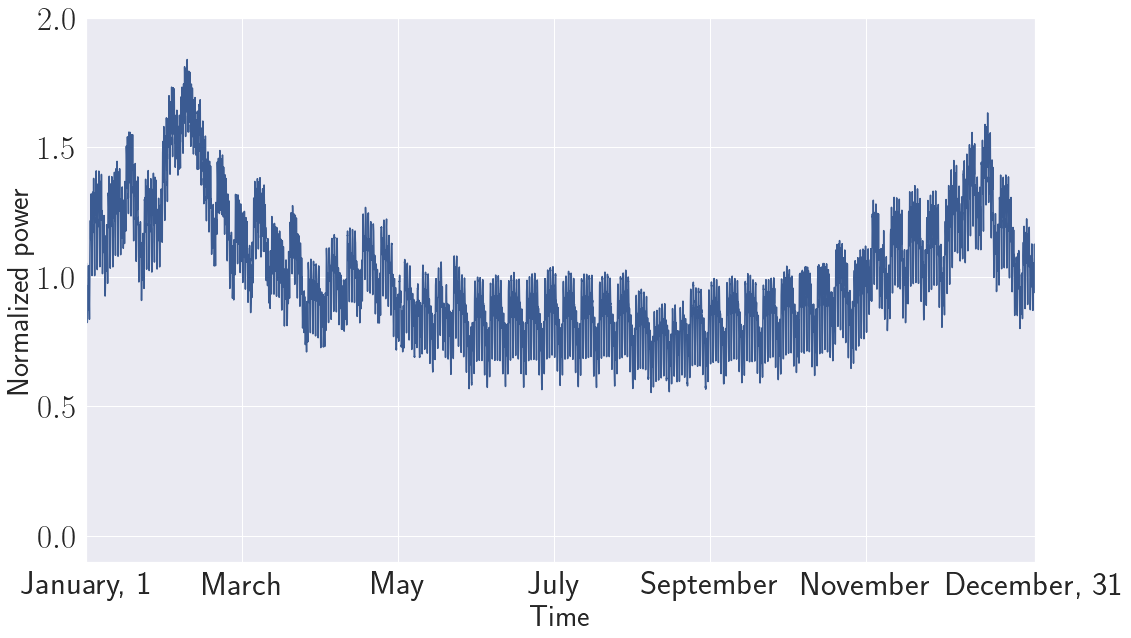

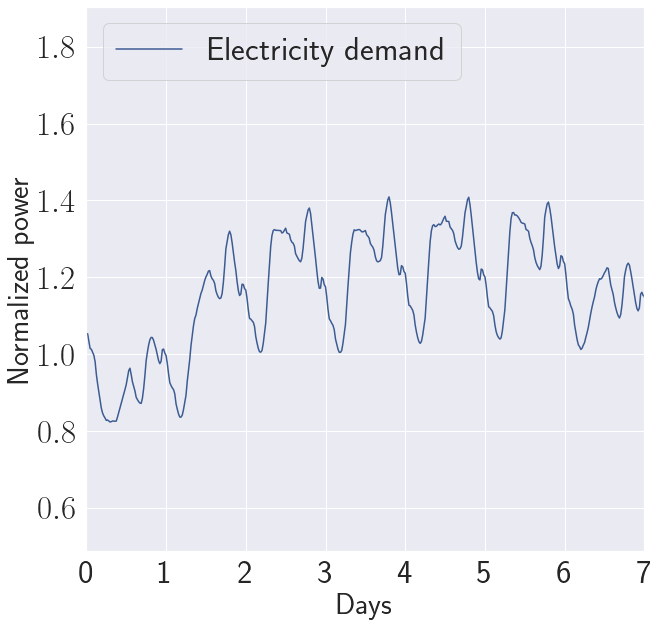

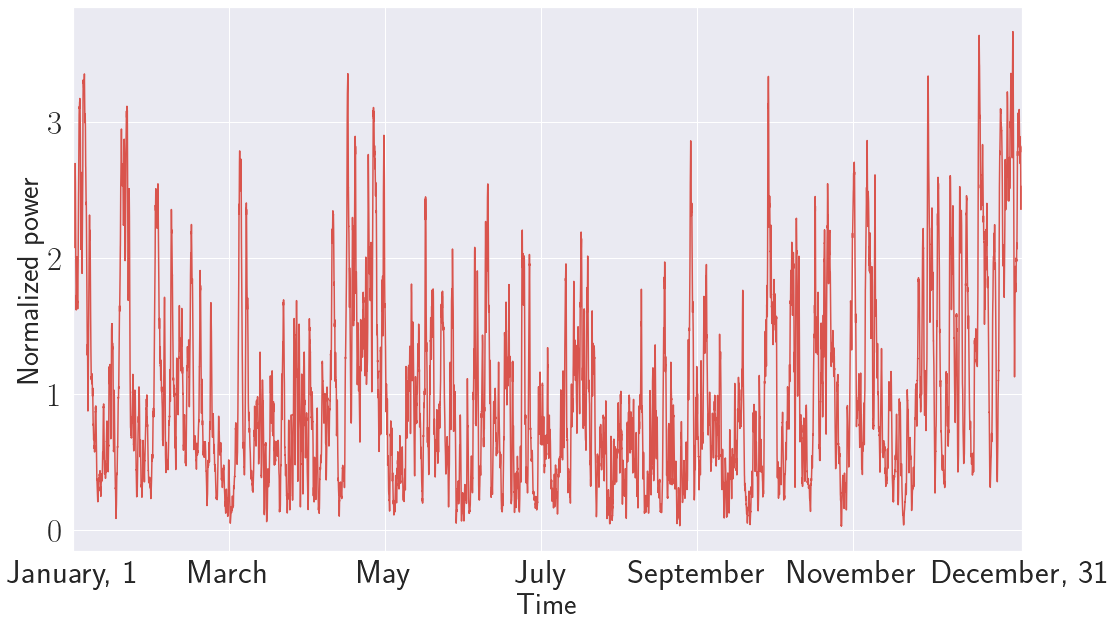

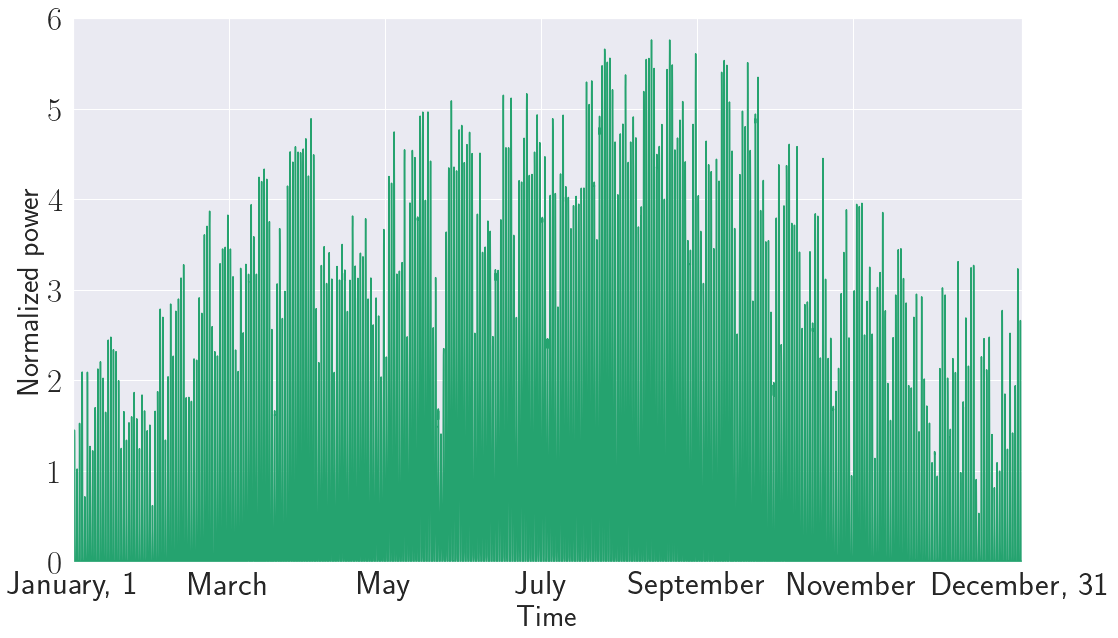

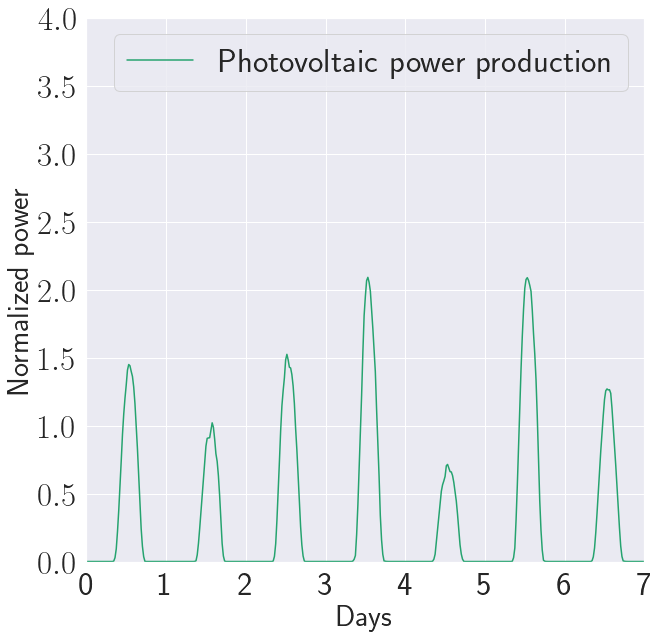

In [26]:
# sns.set(font_scale=2)
time = np.arange(0.,365.,1./64.)
plt.figure(figsize=(17,10))
plt.plot(time, conso, label= 'Electricity demand',color=color_conso)
xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Time",fontsize=30)
# plt.legend(loc='upper left')
plt.xlim(0,365)
plt.ylim(-0.1,2)

plt.figure(figsize=(10,10))
plt.plot(time, conso, label= 'Electricity demand',color=color_conso)
xtick_index =range(365)
xtick_label = range(365)
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Days",fontsize=30)
plt.legend(loc='upper left')
plt.xlim(0,7)
# plt.ylim(-0.1,3.8)

# -----------
plt.figure(figsize=(17,10))
plt.plot(time, wind, label= 'Wind power production',color=color_wind)
xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Time",fontsize=30)
# plt.legend()
plt.xlim(0,365)

plt.figure(figsize=(10,10))
plt.plot(time, wind, label= 'Wind power production',color=color_wind)
xtick_index =range(365)
xtick_label = range(365)
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Days",fontsize=30)
plt.legend()
plt.xlim(0,6)
plt.ylim(0,4)
# ----------

plt.figure(figsize=(17,10))
plt.plot(time, pv, label= 'Photovoltaic power production',color=color_PV)
xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Time",fontsize=30)
# plt.legend()
plt.xlim(0,365)
plt.ylim(0,6)

plt.figure(figsize=(10,10))
plt.plot(time, pv, label= 'Photovoltaic power production',color=color_PV)
xtick_index =range(365)
xtick_label = range(365)
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Days",fontsize=30)
plt.legend()
plt.xlim(0,7)
plt.ylim(0,4)

(-0.1, 3.8)

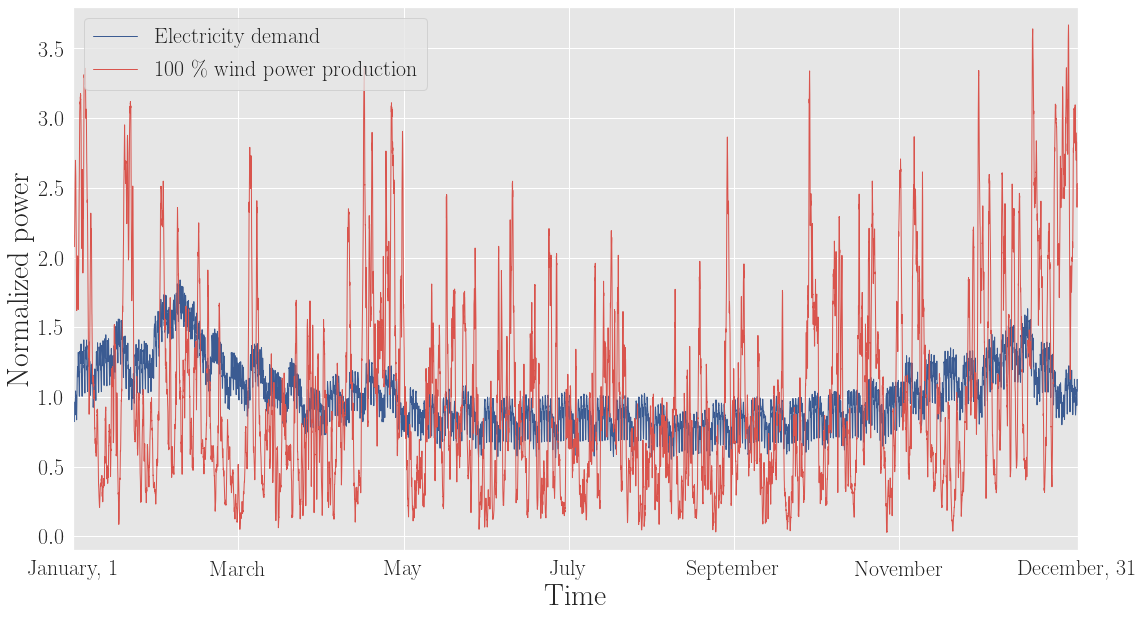

In [13]:
pv_ratio = 0.105
wind_ratio = 0.179+0.071
nucl_ratio=0.531
hydro_ratio=0.114
assert pv_ratio + wind_ratio + nucl_ratio + hydro_ratio == 1

# 
Ampere_prod = pv*pv_ratio +wind*wind_ratio +1-pv_ratio-wind_ratio
plt.figure(figsize=(18,10))
plt.plot(time, conso, label= 'Electricity demand',color=color_conso)
plt.plot(time, wind, label= '100 \% wind power production',color=color_wind)
xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.xticks(xtick_index, xtick_label)
plt.ylabel('Normalized power',fontsize=30)
plt.xlabel("Time",fontsize=30)
plt.legend(loc='upper left')
plt.xlim(0,365)
plt.ylim(-0.1,3.8)

(-0.1, 1.6)

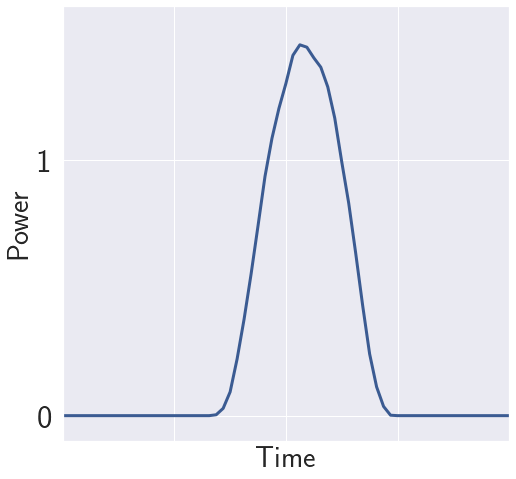

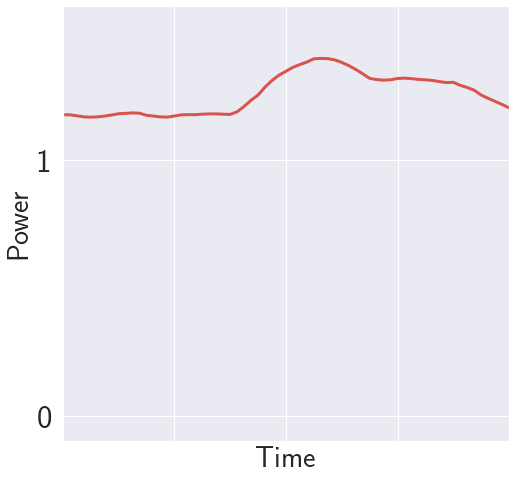

In [14]:
sns.set(font_scale=3)
plt.figure(figsize=(8,8))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.plot(time, pv,color=color_conso, lw = 3)
# xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
# xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.yticks([0,1], ['0', '1'])
plt.ylabel('Power',fontsize=30)
plt.xlabel("Time",fontsize=30)
# plt.legend(loc='upper left')
plt.xlim(0,1)
plt.ylim(-0.1,1.6)

sns.set(font_scale=3)
plt.figure(figsize=(8,8))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.plot(time, Ampere_prod,color=color_wind, lw = 3)
# xtick_index =[0,2*30,4*30, 6*30,8*30,10*30,365]
# xtick_label = ['January, 1', 'March', 'May', 'July', "September", 'November', 'December, 31']
plt.yticks([0,1], ['0', '1'])
plt.ylabel('Power',fontsize=30)
plt.xlabel("Time",fontsize=30)
# plt.legend(loc='upper left')
plt.xlim(0,1)
plt.ylim(-0.1,1.6)

# Starting the wavelet decomposition

In [13]:
'''
First, we to compute the appopriate translations for each year
'''
trans_file = 'new_trans_square_12_18'

trans_square = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'square', do_calc = False)

Importing translations


In [14]:
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine_function' or 'square' sgape
'''
# path_matrix = "saved_matrix\\square_shape\\"
# stacked_betas_square, saved_sheets_square = compute_betas(time_series, stacked_input_data,
#                  vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
#                  trans_square,
#                  path_matrix,
#                  beta_path, wl_shape ='square', imp_matrix = False)

# pkl.dump([stacked_betas_square, saved_sheets_square], open('betas_saved_square' + '.p', "wb"))

[stacked_betas_square, saved_sheets_square] = pkl.load(open('betas_saved_square' + '.p', "rb"))

In [15]:
print(saved_sheets_square.keys())
print(saved_sheets_square['Consommation'].keys())
print(saved_sheets_square['Consommation']["2012"][14]) # 14th time scale

dict_keys(['Consommation', 'Eolien', 'Solaire'])
dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
[-0.16450030884792316]


## Plots
### We represent each year decomposition one the heat maps bellow
### The wavelet transform is also compared with the fourier transform

In [16]:
year = '2018'
path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#

df_conso = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years, time_scales,saved_sheets_square,matrix)
df_eol   = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Eolien', year, years, time_scales, saved_sheets_square,matrix)
df_pv    = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Solaire', year, years, time_scales,  saved_sheets_square,matrix)

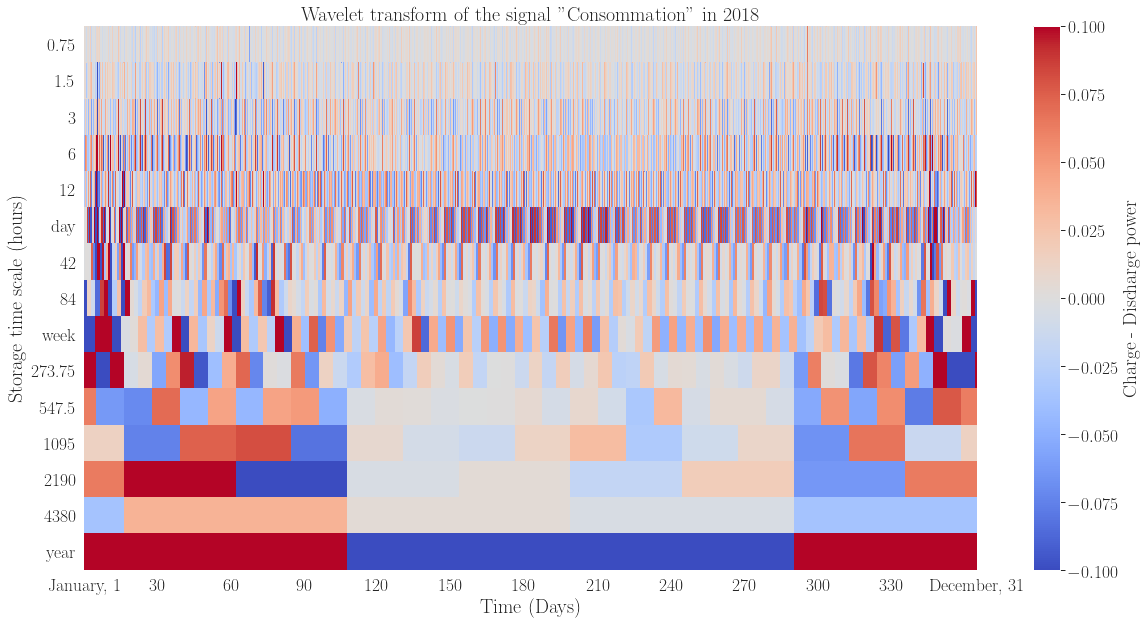

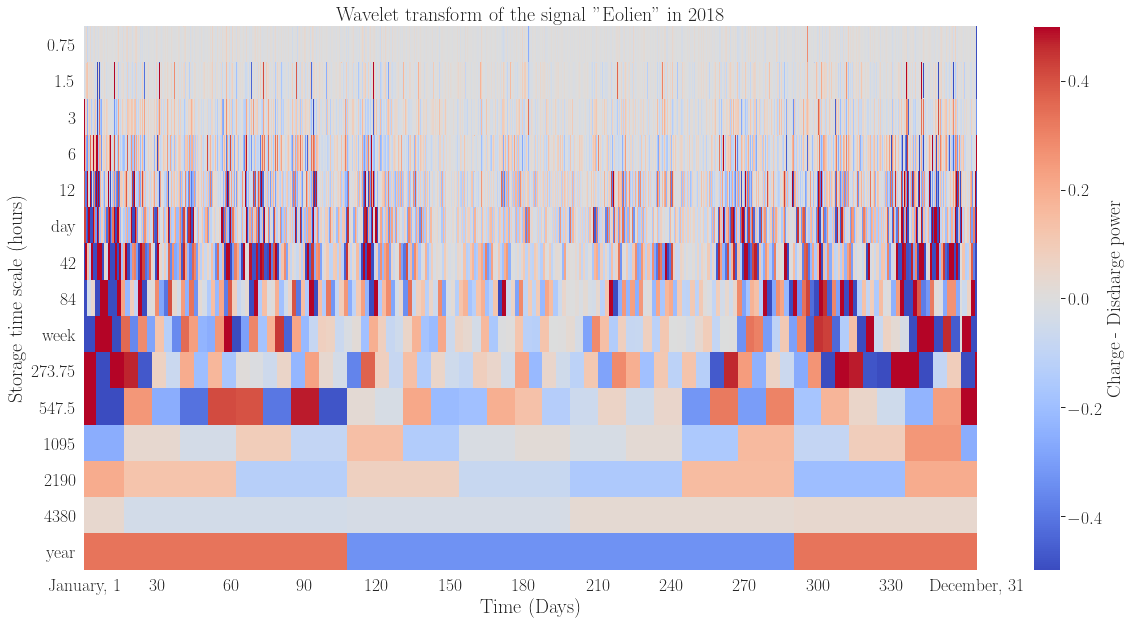

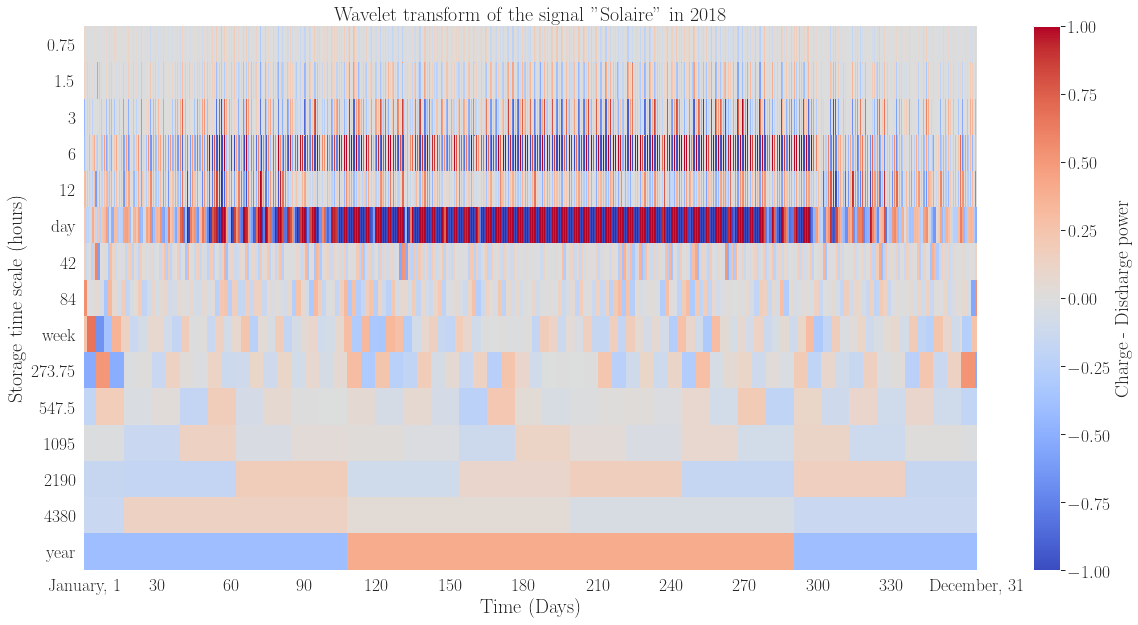

In [17]:
plot_betas_heatmap(df_conso, 'Consommation', year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)
plot_betas_heatmap(df_eol, 'Eolien', year ,ndpd,
                      cmin= -0.5,
                      cmax = 0.5,
                      ccenter= None)
plot_betas_heatmap(df_pv, 'Solaire', year ,ndpd,
                      cmin= -1.,
                      cmax=1.,
                      ccenter= None)


## Comparison with a FFT

C:\Users\AC252489\Documents\These\manuscript_wavelets\plots.py:90: RuntimeWarning: divide by zero encountered in true_divide
  xf = 8760./np.linspace(0, 1.0/(2.0*T), int(N/2))


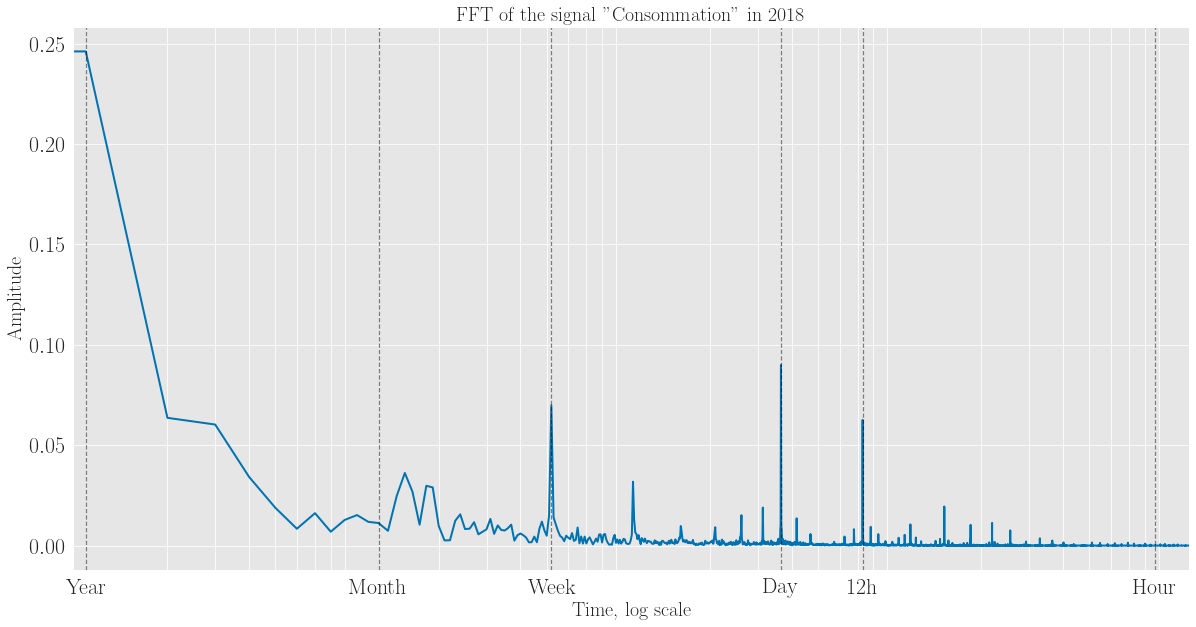

In [18]:
# importlib.reload(plots.fft)
index = years.index(year)
for signal in time_series:
    input_data = stacked_input_data[signal][signal_length*index:signal_length*(index+1)]
    fft(ndpd, dpy, signal, year, input_data)

# Computing Energy, Power, and Nb of Cycles
### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

#### First example with only one year

Consommation
Eolien
Solaire


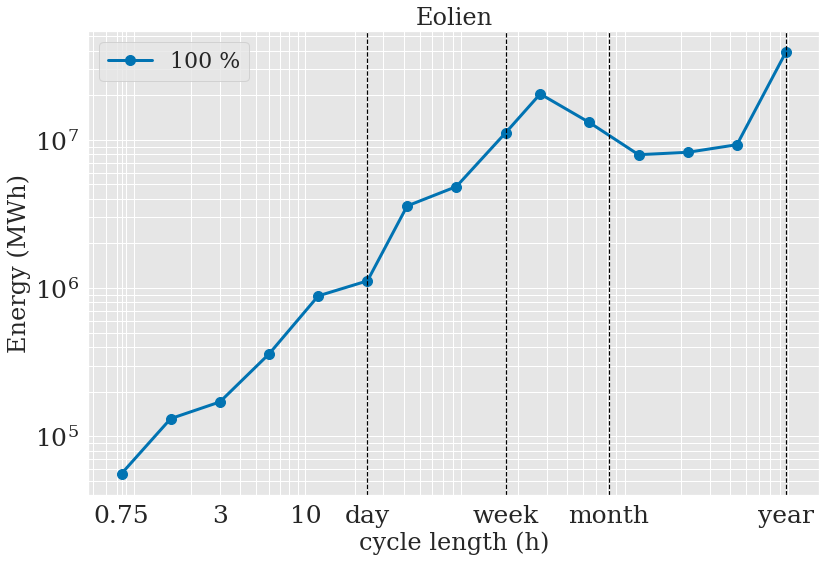

In [19]:
#
# Define here the energy mix, the years you want to include to the wavelet decomposition
chosen_years = ['2018']
short_stacked_betas = stack_betas(saved_sheets_square, time_series, chosen_years)
#
scenario_name = 'Eolien'
conso = short_stacked_betas['Consommation']
prod =  short_stacked_betas['Eolien']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

In [20]:
results['serv']

array([[ 3782673.00761627],
       [11657793.97573228],
       [15746060.47831639],
       [25711035.10447619],
       [36527575.40212686],
       [53265300.31378466],
       [71442318.72274838],
       [61137775.07978558],
       [74274619.40017498],
       [94916845.1066143 ],
       [60848533.57556613],
       [22263161.77186897],
       [22341463.10867484],
       [13458024.63252819],
       [39241988.95174933]])

Consommation
Eolien
Solaire


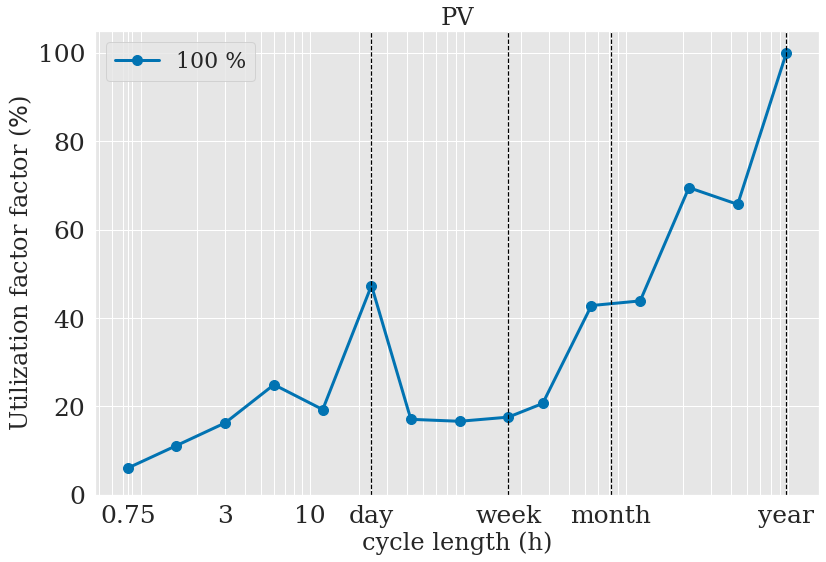

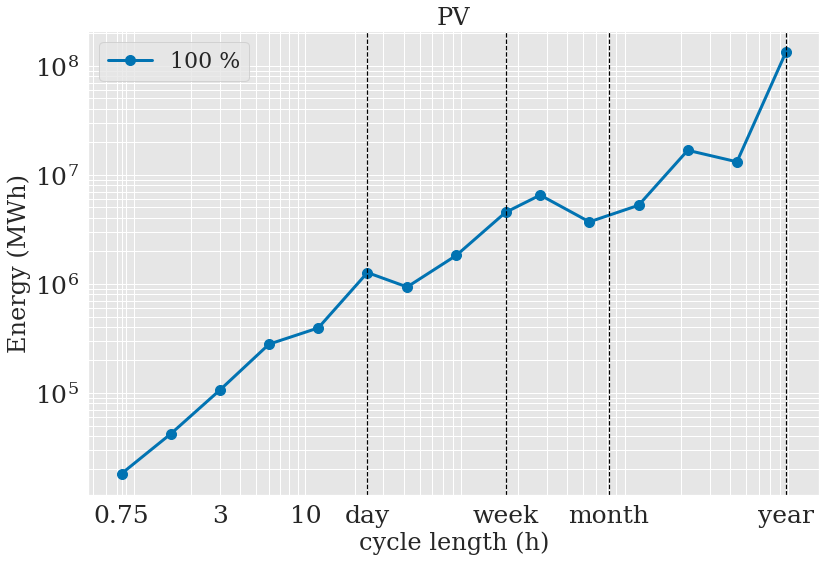

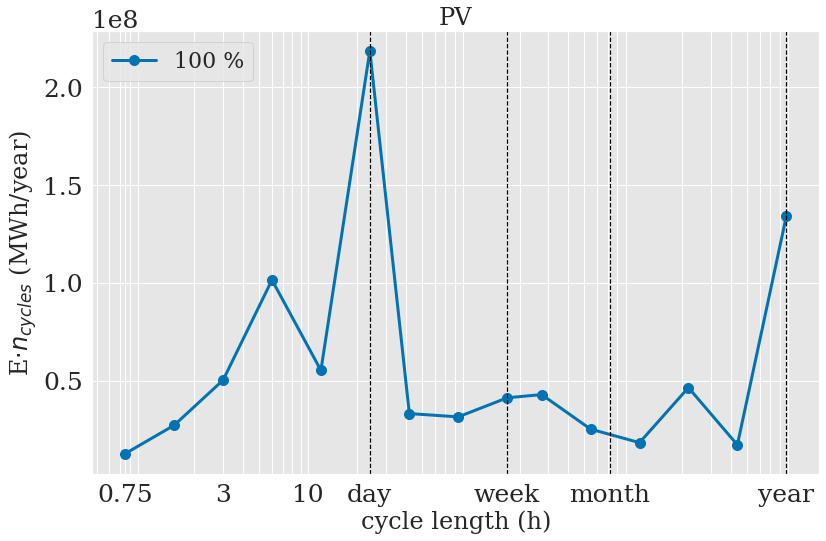

In [21]:
#
# Define here the energy mix, the years you want to include to the wavelet decomposition
chosen_years = ['2018']
short_stacked_betas = stack_betas(saved_sheets_square, time_series, chosen_years)
#
scenario_name = 'PV'
conso = short_stacked_betas['Consommation']
prod =  short_stacked_betas['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

In [22]:
results['serv']

array([[1.27677772e+07],
       [2.72598259e+07],
       [5.03151612e+07],
       [1.01520714e+08],
       [5.53011088e+07],
       [2.18632058e+08],
       [3.32317939e+07],
       [3.15481359e+07],
       [4.12990753e+07],
       [4.29391145e+07],
       [2.52846769e+07],
       [1.83799746e+07],
       [4.65014588e+07],
       [1.72418130e+07],
       [1.34071056e+08]])

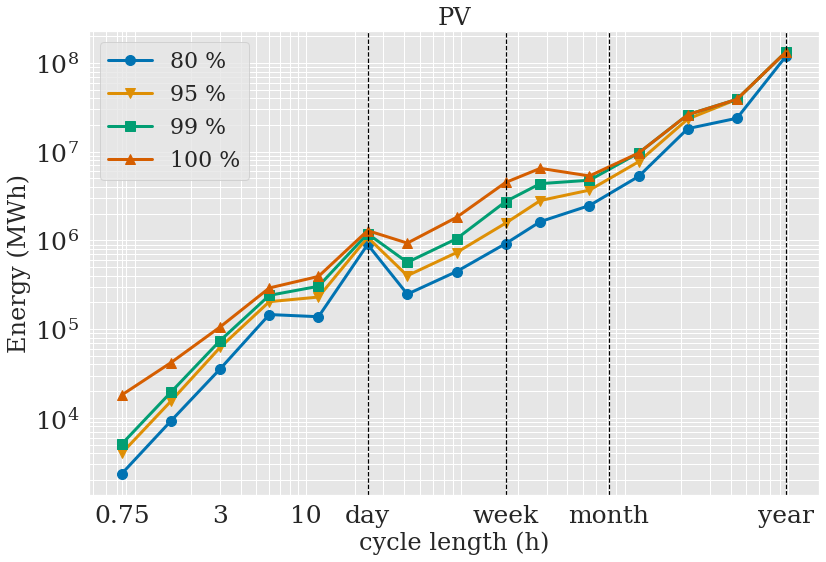

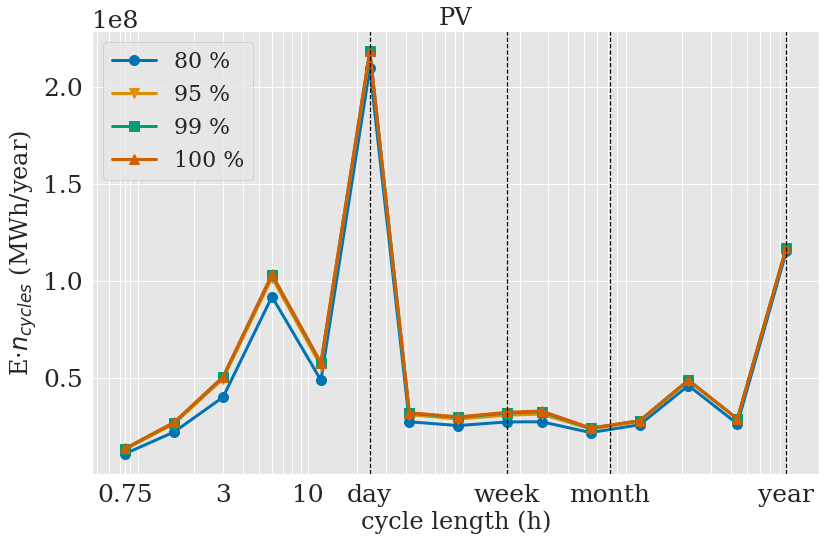

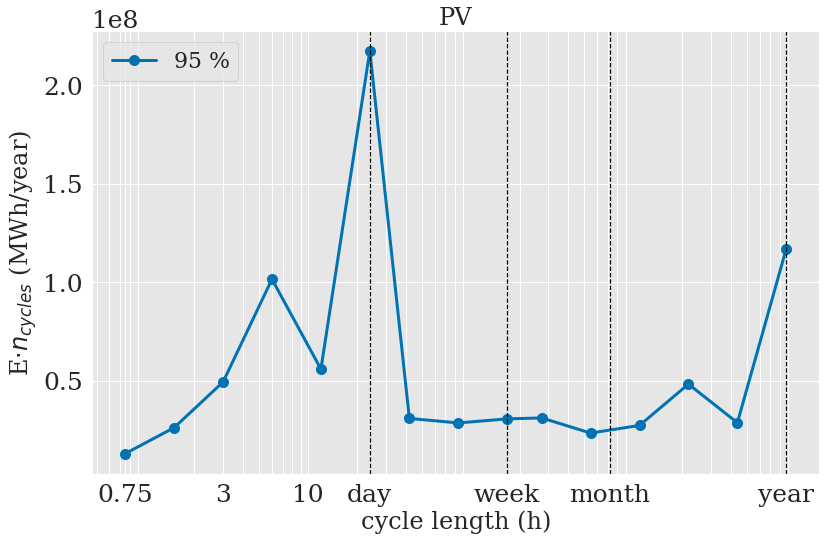

In [23]:
scenario_name = 'PV'
conso = stacked_betas_square['Consommation']
prod =  stacked_betas_square['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

satisfactions = [95]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

array([0.95862128, 0.94252514, 0.91797337, ..., 0.99713225, 1.00952097,
       1.00791826])

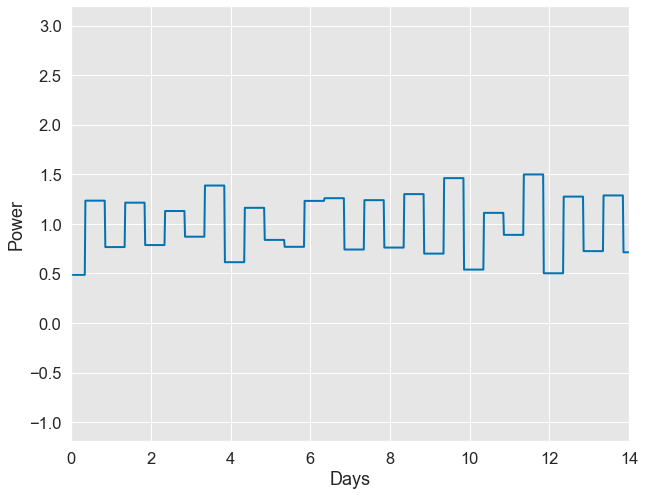

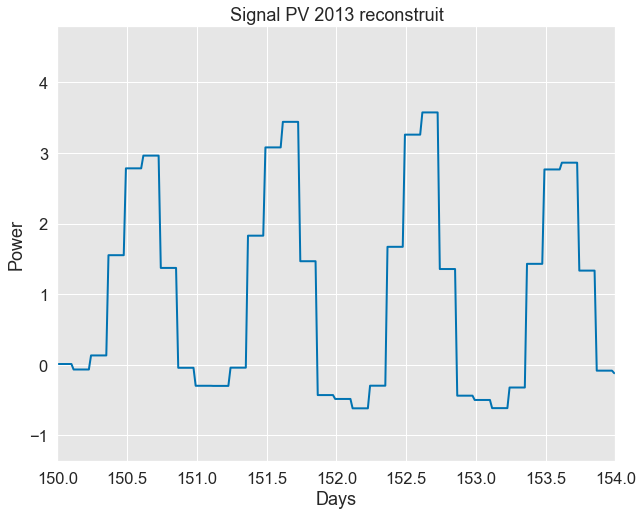

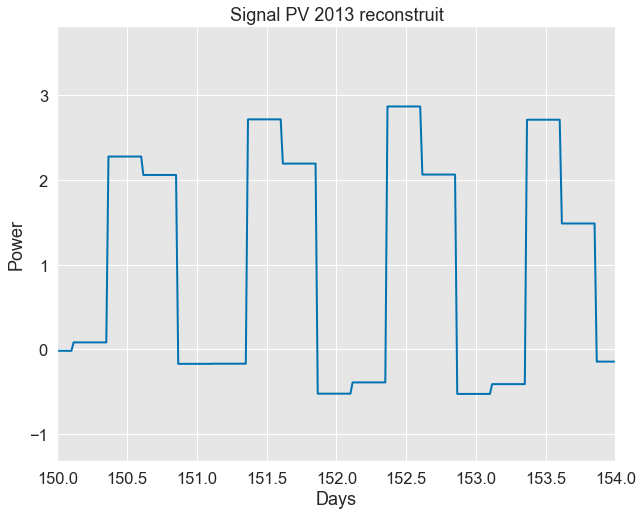

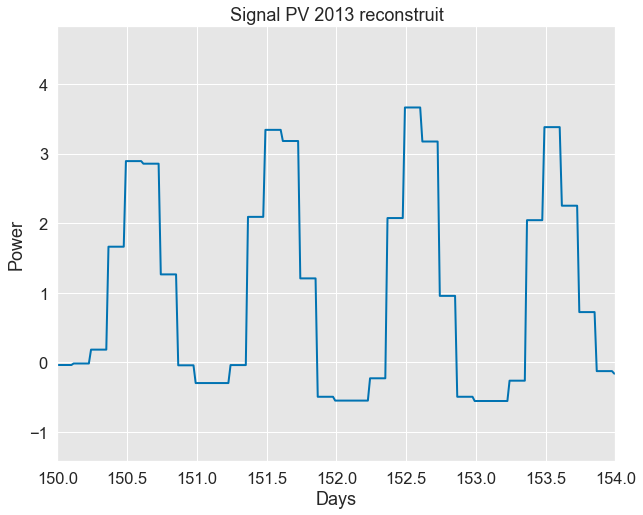

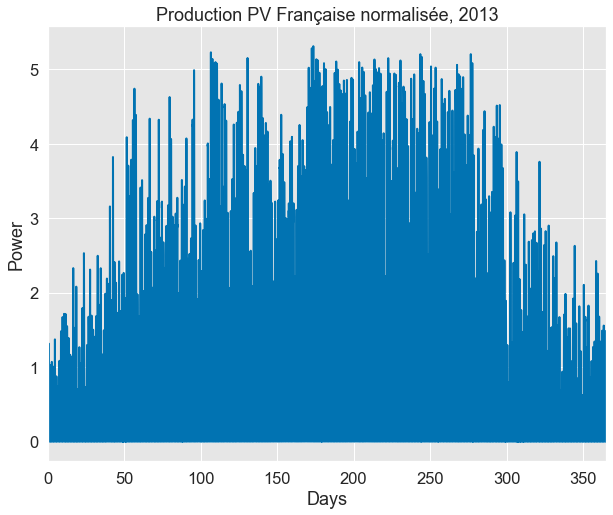

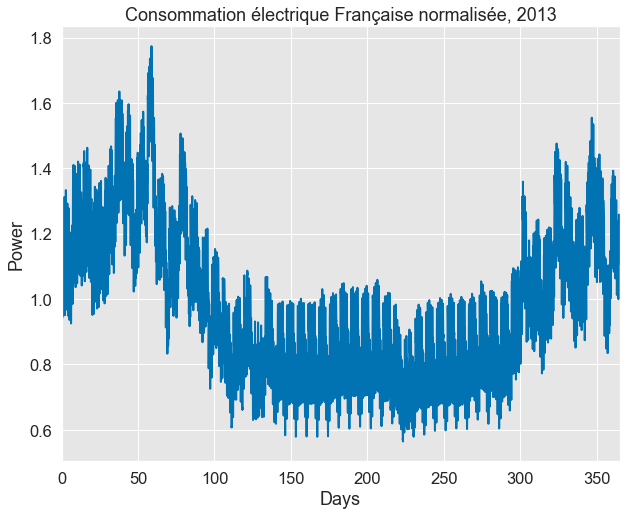

In [24]:
#
# Importing Matrix for the reconstruction
year = '2018'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#

reconstruct(time_scales, [24],
                matrix,saved_sheets_square['Solaire'][year], "",
                xmin=0, xmax=14,
                dpy=365, dpd=64,
                add_offset=True)


reconstruct(time_scales, [6,24],
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)


reconstruct(time_scales, [12,24],
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [6,12,24],
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['Solaire'][year], "Production PV Française normalisée, 2013",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['Consommation'][year], "Consommation électrique Française normalisée, 2013",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.],
                matrix,saved_sheets_square['Consommation'][year], "Consommation électrique Française normalisée, 2013",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

array([1.06816376, 1.06816376, 1.06816376, ..., 1.06816376, 1.06816376,
       1.06816376])

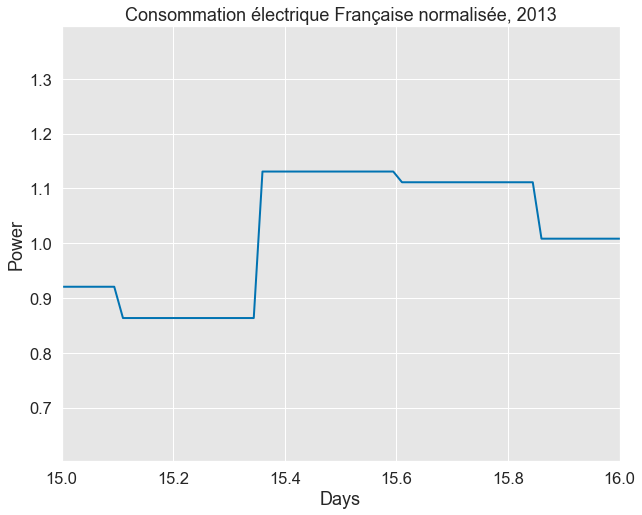

In [25]:
reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['Consommation'][year], "Consommation électrique Française normalisée, 2013",
                xmin=15, xmax=16,
                dpy=365, dpd=64,
                add_offset=True)
reconstruct(time_scales, [12., 24.],
                matrix,saved_sheets_square['Consommation'][year], "Consommation électrique Française normalisée, 2013",
                xmin=15, xmax=16,
                dpy=365, dpd=64,
                add_offset=True)

## Reconstruct all time scales of the wind residual demand

In [26]:
year = ['2012']
CmP = []
for i in range(len(time_scales)):
    CmP.append(np.asarray( [saved_sheets_square['Consommation'][year[0]][i][k] - saved_sheets_square['Eolien'][year[0]][i][k] for k in range( len(saved_sheets_square['Eolien'][year[0]][i]) ) ]) )
CmP.append([0.])
CmP = np.asarray(CmP)

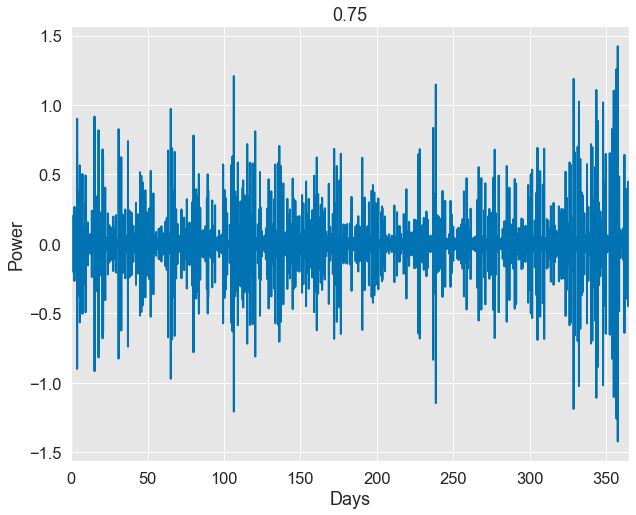

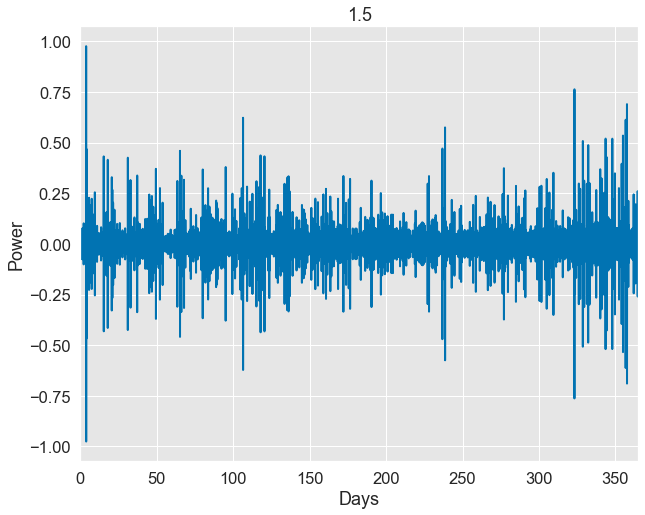

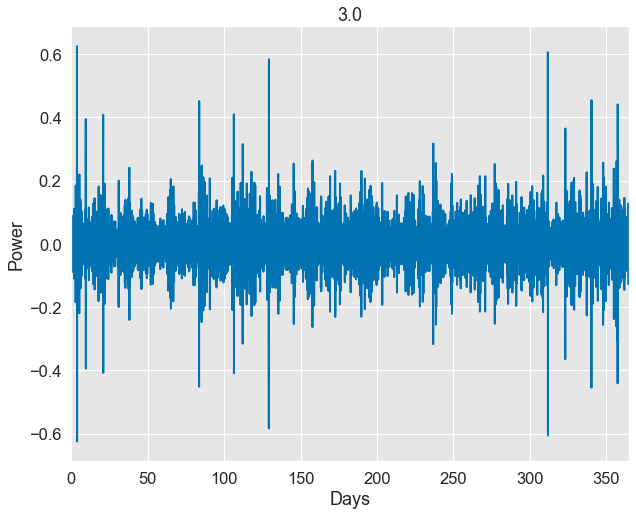

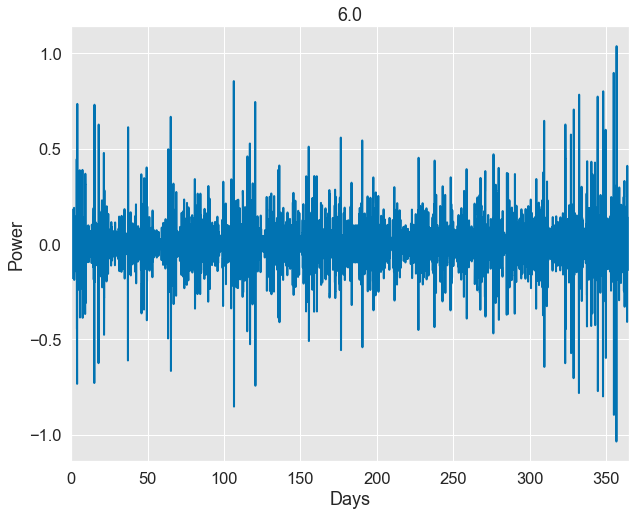

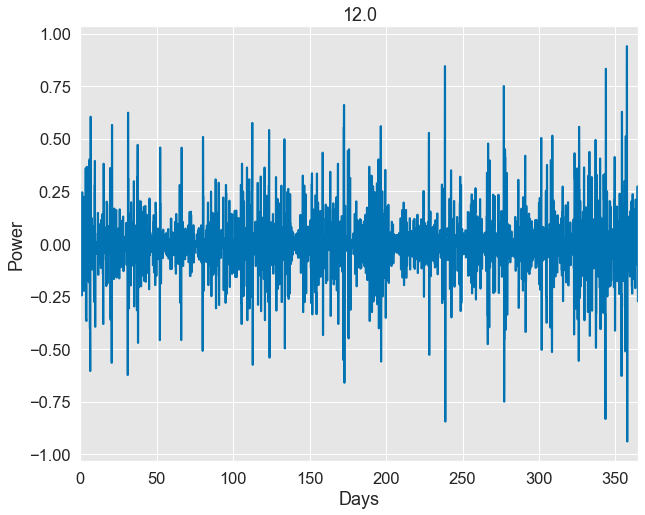

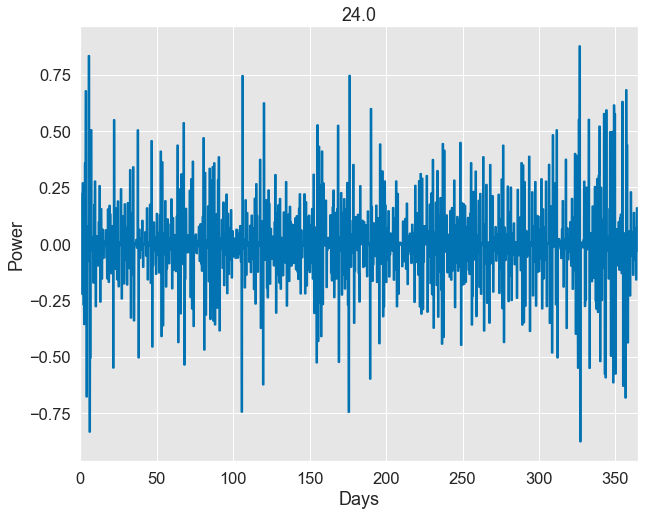

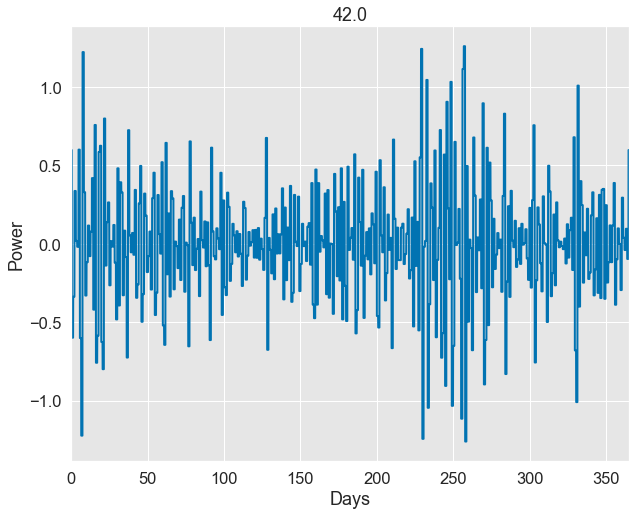

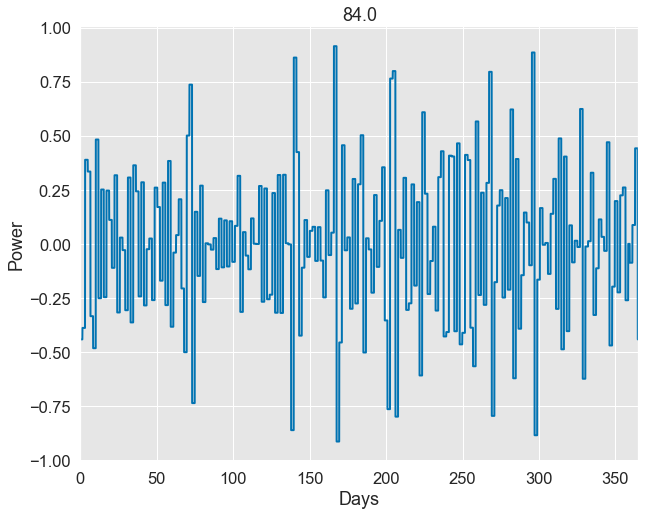

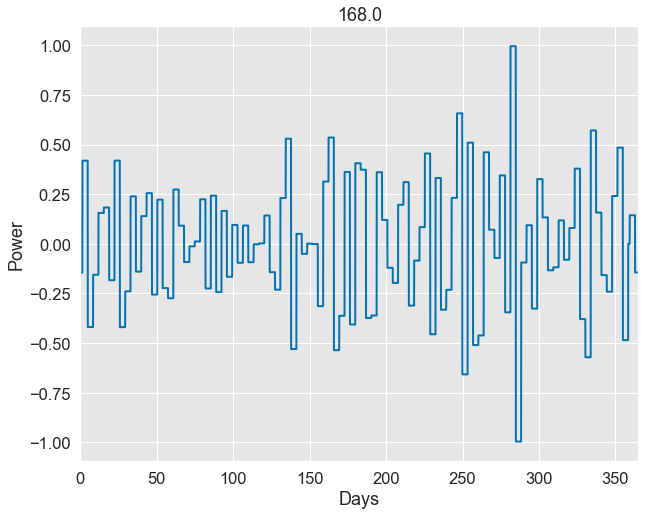

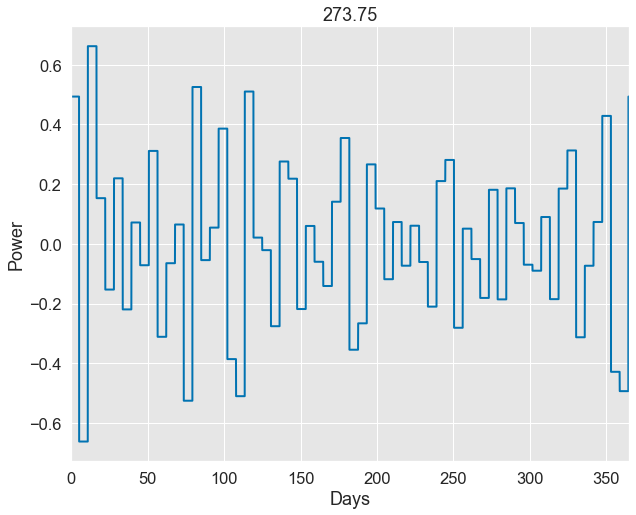

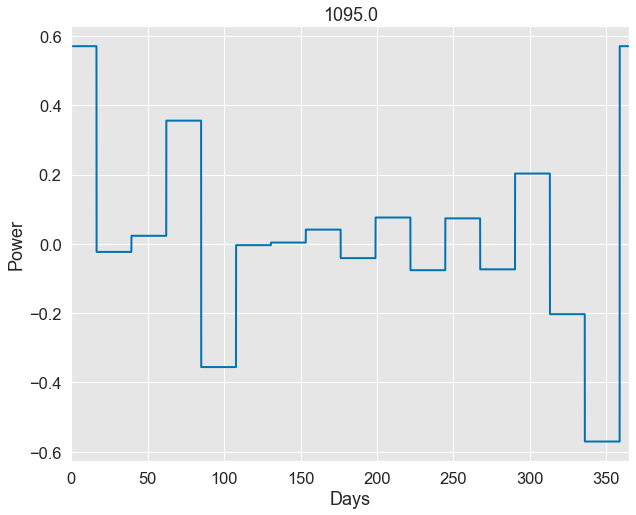

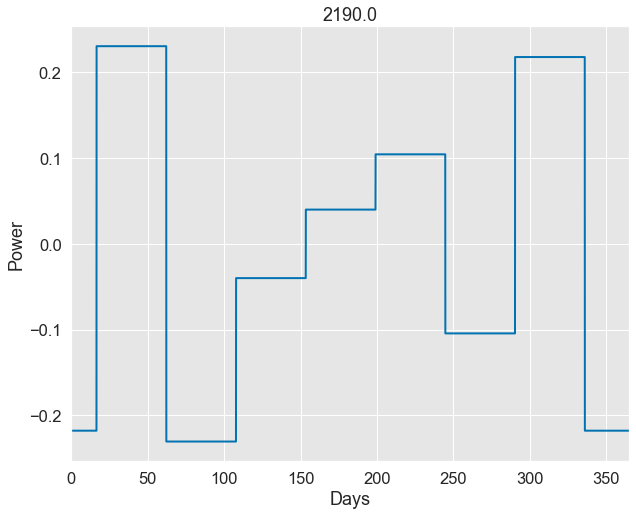

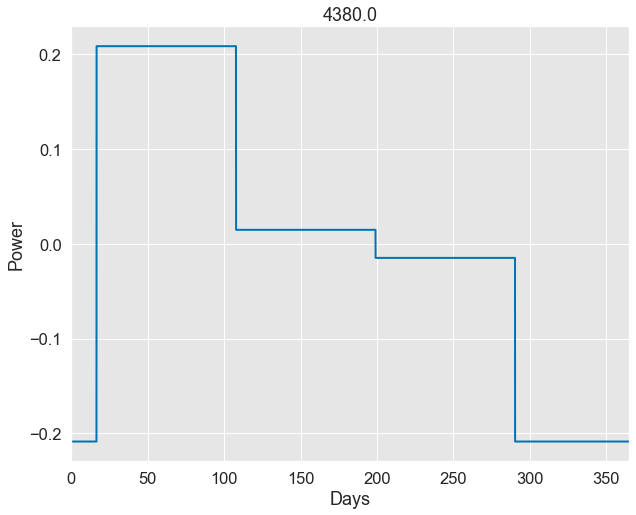

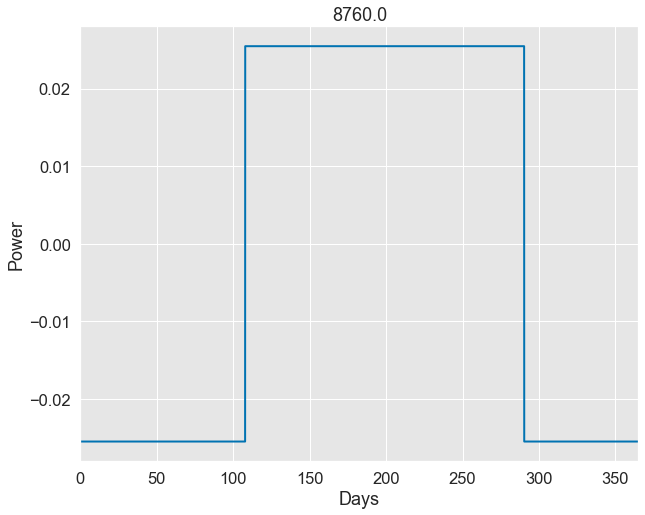

In [27]:
signal_wl = []
for i, ts in enumerate(time_scales):
    signal_wl.append(reconstruct(time_scales, [ts],
                matrix,CmP, str(ts),
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True))

In [28]:
signal_wl[-1]

array([-0.02546846, -0.02546846, -0.02546846, ..., -0.02546846,
       -0.02546846, -0.02546846])

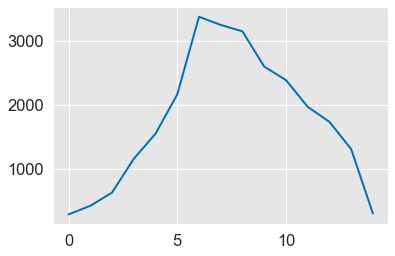

In [29]:
Service = [sum(signal_wl[i][signal_wl[i]>0]) for i in range(len(signal_wl))]

plt.plot(Service)


In [30]:
Service[-1]

297.4715784706503

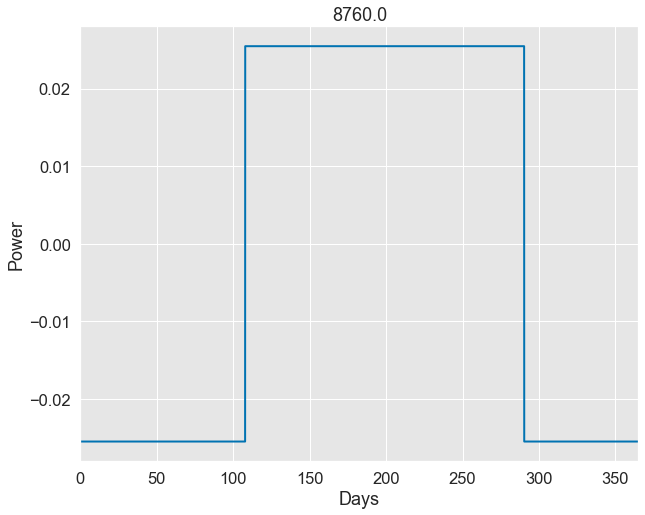

In [31]:
tutu = reconstruct(time_scales, [ts],
                matrix,CmP, str(ts),
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

# Investigation of the correlation at the week scale between Wind and consumption signal in 2018

array([0.82001766, 0.82001766, 0.82001766, ..., 0.82001766, 0.82001766,
       0.82001766])

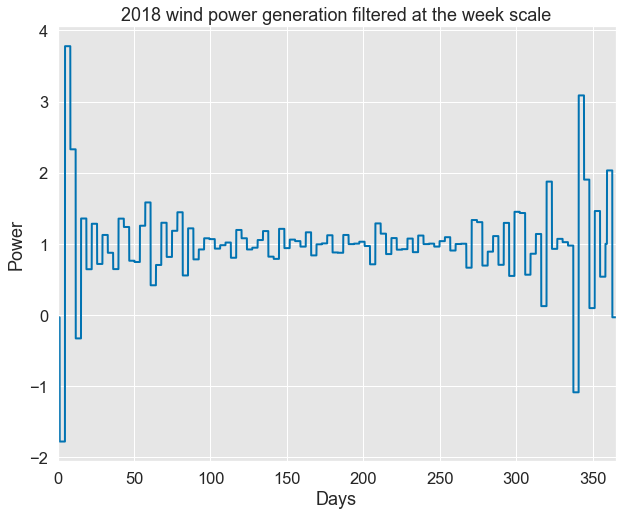

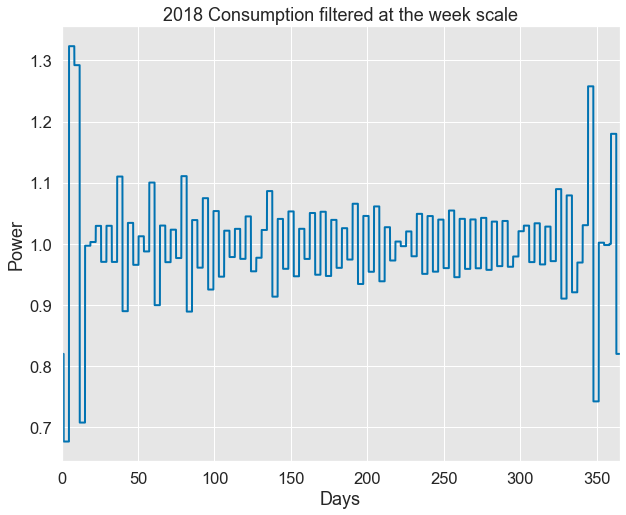

In [32]:
year = '2018'

path_matrix = "saved_matrix\\square_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#
reconstruct(time_scales, [168],
                matrix,saved_sheets_square['Eolien'][year], "2018 wind power generation filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [168],
                matrix,saved_sheets_square['Consommation'][year], "2018 Consumption filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

array([1.2064956, 1.2064956, 1.2064956, ..., 1.2064956, 1.2064956,
       1.2064956])

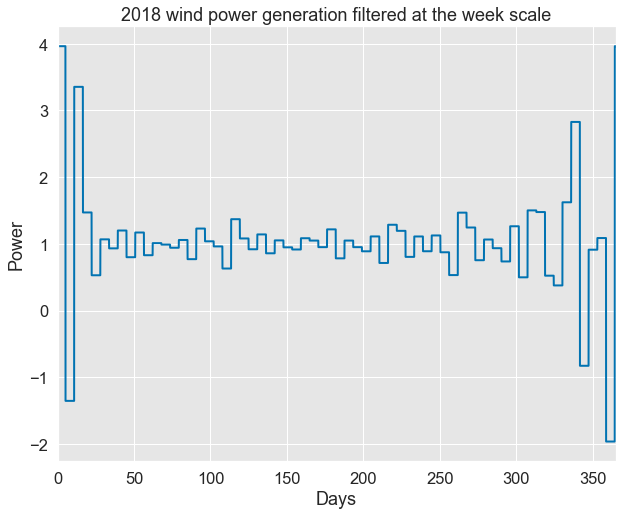

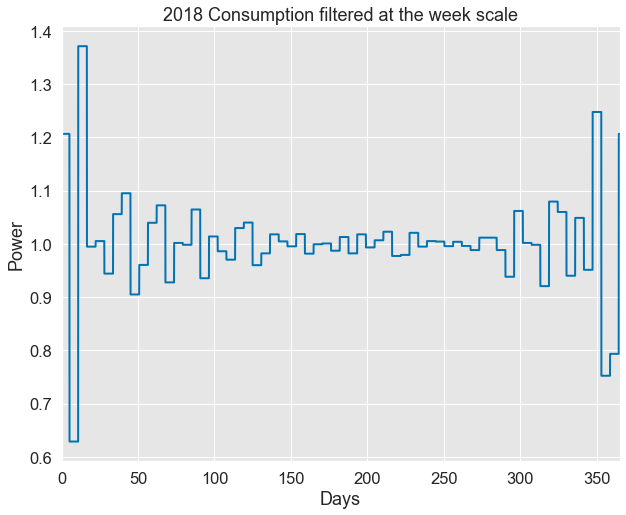

In [33]:
# For the scame 11 days 

reconstruct(time_scales, [273.75],
                matrix,saved_sheets_square['Eolien'][year], "2018 wind power generation filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)


reconstruct(time_scales, [273.75],
                matrix,saved_sheets_square['Consommation'][year], "2018 Consumption filtered at the week scale", xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

Text(0.5, 1.0, '1 day time-scale')

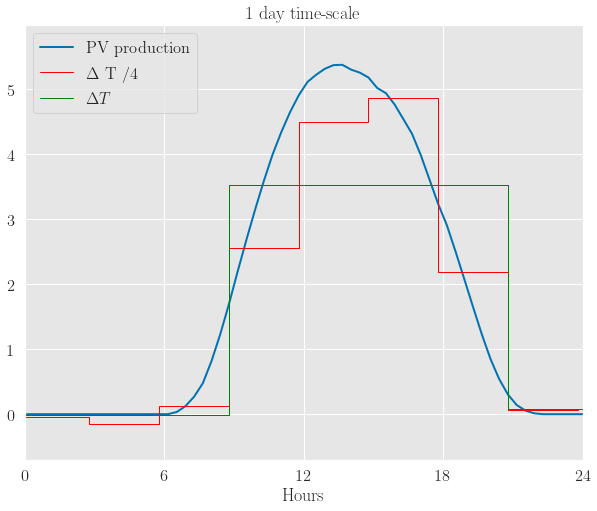

In [34]:
## ----
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

beta_sheet = saved_sheets_square['Solaire'][year]

xmin=155
xmax=156
dpy=365
dpd=64
            


time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380., 8760.] # cycles length, in hours
reconstructed_time_scales = time_scales
    # Concat time scales
concat_betas = []
for i, ts in enumerate(time_scales):
    if ts in reconstructed_time_scales:
        concat_betas.extend(beta_sheet[i])
    else:
        concat_betas.extend([0.] * len(beta_sheet[i]))


concat_betas.extend(beta_sheet[-1])

# PLots options
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("colorblind")  # set colors palettte
plt.rc('text', usetex=True)  # To get Latex style in the figures
plt.rc('font', family='serif')

#
time = np.linspace(0, dpy, dpy * dpd)
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot(time, np.dot(matrix, concat_betas[::-1]), label = 'PV production')
plt.xlim(xmin, xmax)
plt.xlabel('Hours')
plt.ylabel('')
plt.xticks([155.,155.25,155.5,155.75,156.], [0,6,12,18,24])
#---------
reconstructed_time_scales = [6., 24.]
    # Concat time scales
concat_betas = []
for i, ts in enumerate(time_scales):
    if ts in reconstructed_time_scales:
        concat_betas.extend(beta_sheet[i])
    else:
        concat_betas.extend([0.] * len(beta_sheet[i]))


concat_betas.extend([0.])
plt.step(time, np.dot(matrix, concat_betas[::-1])+1.8, color='red', linewidth=1,  label = r'$\Delta$ T /4', where = 'post')
# -----
reconstructed_time_scales = [24]
    # Concat time scales
concat_betas = []
for i, ts in enumerate(time_scales):
    if ts in reconstructed_time_scales:
        concat_betas.extend(beta_sheet[i])
    else:
        concat_betas.extend([0.] * len(beta_sheet[i]))


concat_betas.extend([0.])
plt.step(time, np.dot(matrix, concat_betas[::-1])+1.8, color='green', linewidth=1, label = r'$\Delta T $', where = 'post')

plt.legend()
plt.title('1 day time-scale')

In [35]:
print(beta_sheet)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.020184654222770333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007225313105284708, 0.0537081607494322, 0.1271655106531831, 0.1471555435782204, 0.10910222788994722, 0.11006560297100589, 0.05274478566864943, -0.018785814073825787, -0.033958971594879796, -0.12162610393942185, -0.17702017107971402, -0.18135535894343138, -0.07008553712135376, -0.0019267501614187446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.046482847644098955, 0.14884144996907245, 0.18882151581891476, 0.13439082375847217, 0.10187691478495219, 0.05707997353182756, -0.013728094899994736, -0.09392907036882718, -0.14908229373964127, -0.17918776501130965, -0.1628103886397635, -0.06791794318976778, -0.001445062621066481, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06864047450035618, 0.20592142350089523, 0.17244413944685433, 0.13366829244795245, 0.06743625564961214, 0.01

In [36]:
len(beta_sheet)

16

### Analysis
--

There is, in 2018, correlations between wind and consumption cycles at the week and 11 days scale, in 2018.

In other words, we saw that in winter, (december - january) with cold weather and strong electricity consumptions over a week or more, there is luckily a lot of wind.

# Sine wavelets
## We analyse here the results between sine_function wavelets and square wavelets

In [37]:
'''
First, we to compute the appopriate translations for each year
'''
trans_file = 'new_trans_sine_12_18'

trans_sine = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'sine', do_calc=False)

Importing translations


In [38]:
beta_path = "betas\\sine_shape\\"
#
path_matrix = "saved_matrix\\sine_shape\\"

# stacked_betas_sine, saved_sheets_sine = compute_betas(time_series, stacked_input_data,
#                  vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
#                  trans_sine,
#                  path_matrix,
#                  beta_path, wl_shape ='sine', imp_matrix = False)

# pkl.dump([stacked_betas_sine, saved_sheets_sine], open('betas_saved_sine' + '.p', "wb"))

[stacked_betas_sine, saved_sheets_sine] = pkl.load(open('betas_saved_sine' + '.p', "rb"))

## Heatmaps

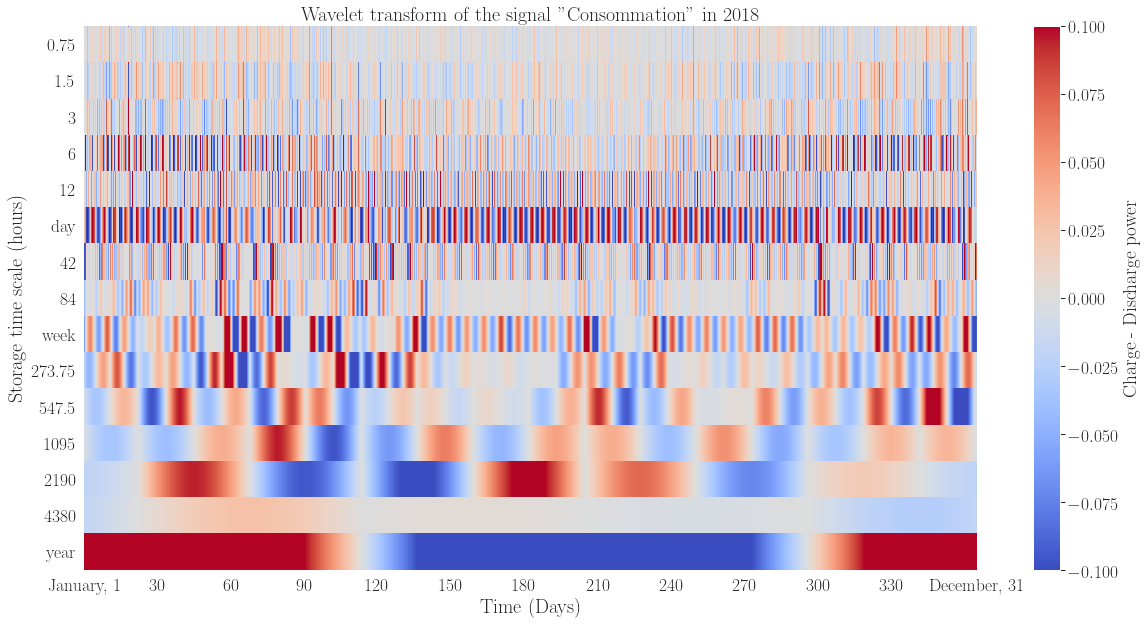

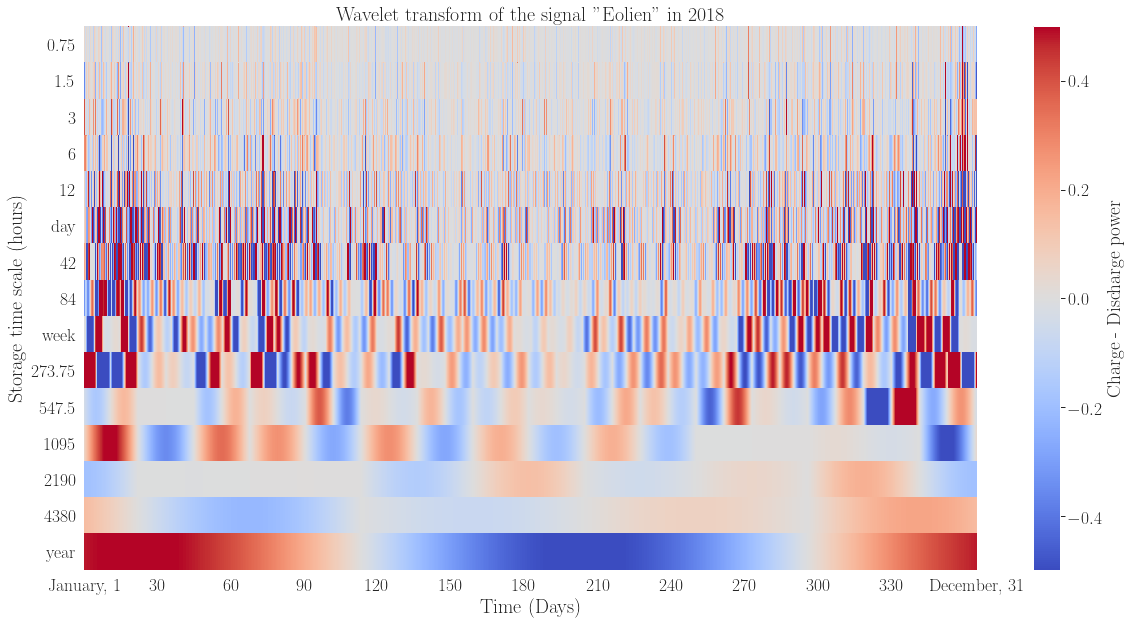

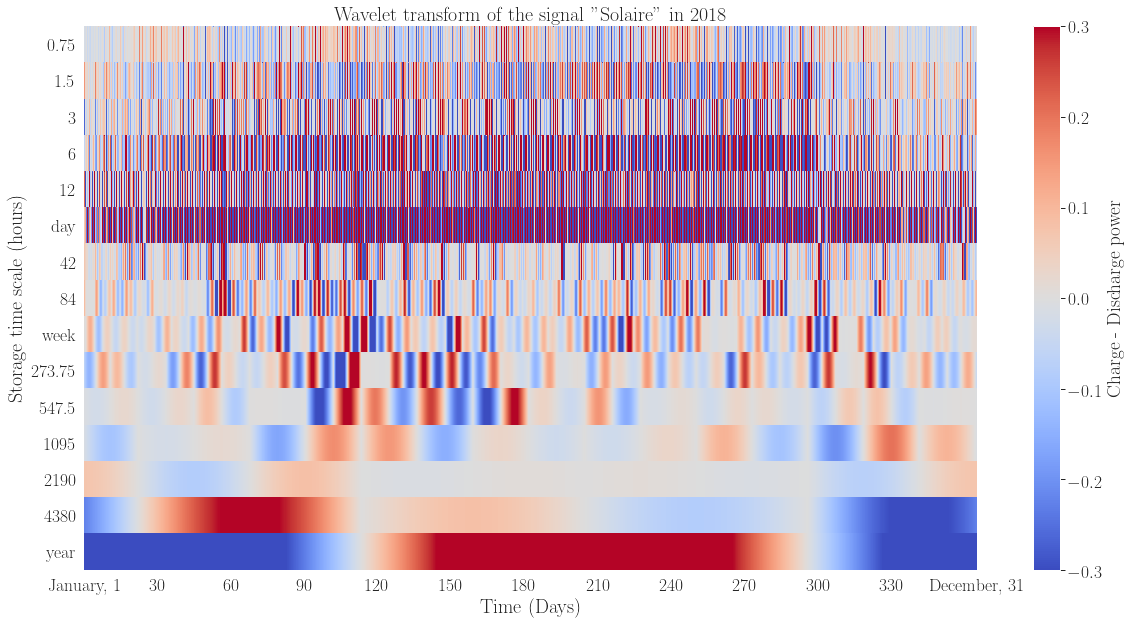

In [39]:
year = '2018'
path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
#

df_conso_sine = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years, time_scales,saved_sheets_sine,matrix)
df_eol_sine   = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Eolien', year, years, time_scales, saved_sheets_sine,matrix)
df_pv_sine    = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Solaire', year, years, time_scales,  saved_sheets_sine,matrix)
# -------------

plot_betas_heatmap(df_conso_sine, 'Consommation', year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)
plot_betas_heatmap(df_eol_sine, 'Eolien', year ,ndpd,
                      cmin= -0.5,
                      cmax = 0.5,
                      ccenter= None)
plot_betas_heatmap(df_pv_sine, 'Solaire', year ,ndpd,
                      cmin= -0.3,
                      cmax= 0.3,
                      ccenter= None)


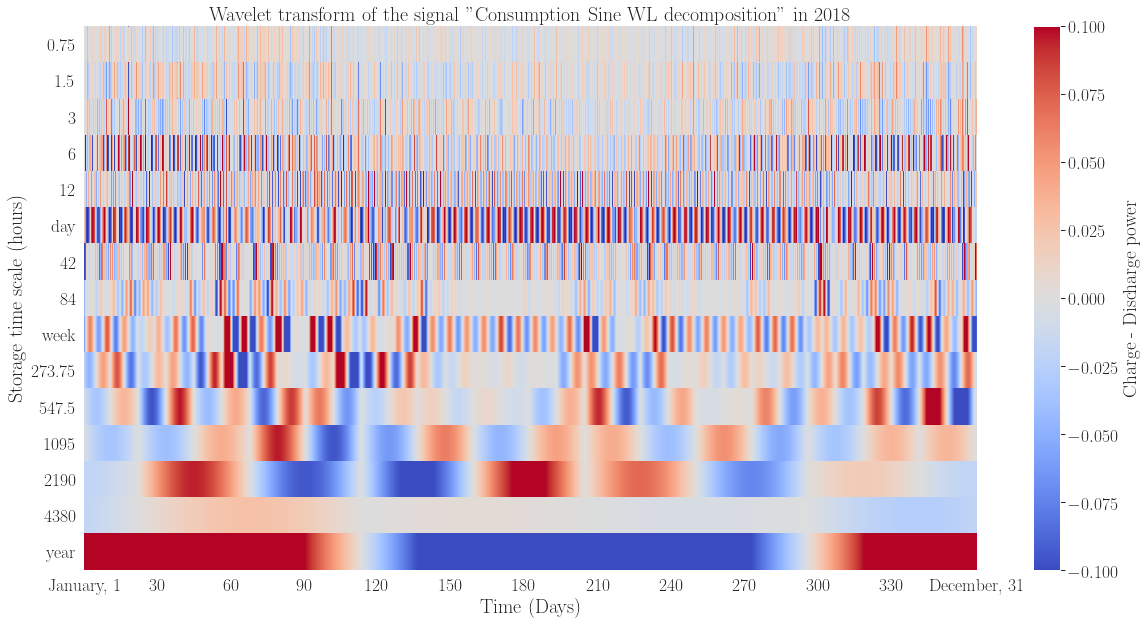

In [40]:
year = '2018'
df_conso_square = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years, time_scales,saved_sheets_square, matrix)
df_conso_sine = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', year, years,time_scales, saved_sheets_sine, matrix)


plot_betas_heatmap(df_conso_square, 'Consumption, Square WL decomposition', year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

plot_betas_heatmap(df_conso_sine, 'Consumption Sine WL decomposition', year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

## Signal reconstruction
--

array([-2.36113298e-09, -7.93537029e-08, -3.28472398e-08, ...,
       -7.52335390e-08,  1.68324788e-08,  2.61788045e-08])

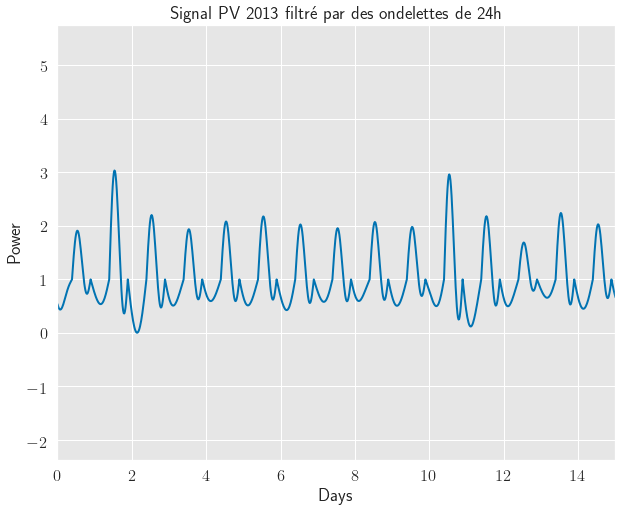

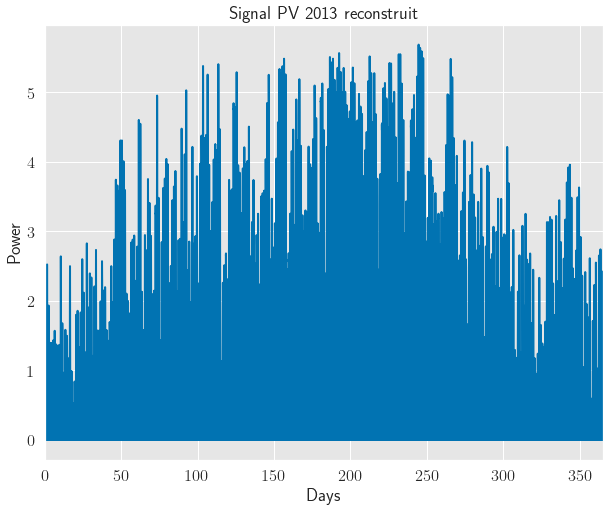

In [41]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

#
reconstruct(time_scales, [24],
                matrix,saved_sheets_sine['Solaire'][year], "", xmin=0, xmax=14,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [12,24],
                matrix,saved_sheets_sine['Solaire'][year], "Signal PV 2013 filtré par des ondelettes de 24h", xmin=0, xmax=15,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_sine['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

## Computin E, P, N
--

***Beware:*** Energy calculation is still carried as before. However, since the wavelet shap has changed, it's value is now different

- However, Energy and Service should only be multiplied by 2/pi =~ 0.64

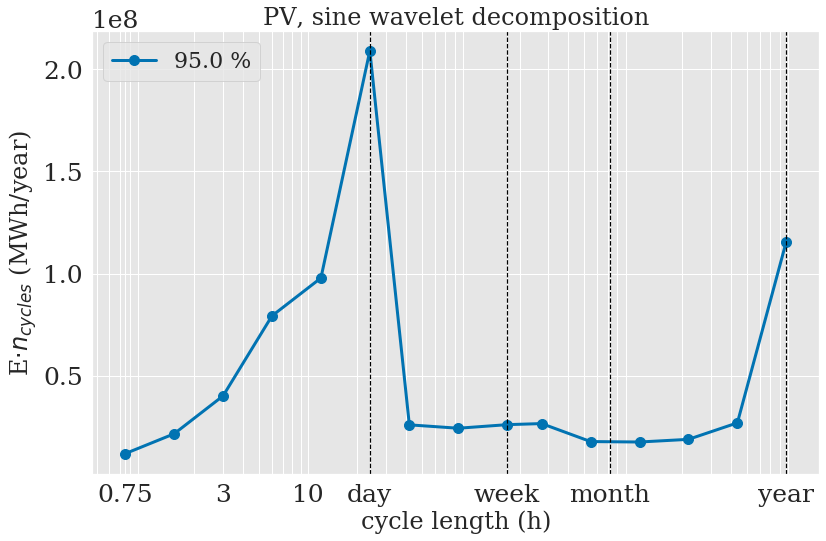

In [42]:
scenario_name = 'PV, sine wavelet decomposition'
sine_conso = stacked_betas_sine['Consommation']
sine_prod =  stacked_betas_sine['Solaire']

sine_pmc = [np.array(sine_prod[i]) - np.array(sine_conso[i]) for i in range(len(time_scales)) ]

satisfactions = [95.]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_sine = calc_epn(sine_pmc, satisfactions, time_scales, dpy, load_factor, shape = 'sine')
plot_EPN(results_sine['emax'], results_sine['pmax'], results_sine['n'], results_sine['uf'], results_sine['serv'],
         time_scales, satisfactions, scenario_name )

# Impact of translations on the results
--


We proceed here to EPN calculation without optimizing the translation of mother wavelets of days, weeks and year

In [43]:
#
# Create translations full of zeros
zero_trans = []
Nyears = int(len(stacked_input_data['Consommation'])/(ndpd*dpy) )
for i in range(Nyears):
    zero_trans.append([0,0,0])

In [44]:
path_matrix = "saved_matrix\\square_shape\\no_trans\\"
beta_path = "betas\\square_shape_no_trans\\"

# stacked_betas_square_no_trans, saved_sheets_square_no_trans = compute_betas(time_series, stacked_input_data,
#                  vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
#                  zero_trans,
#                  path_matrix,
#                  beta_path, wl_shape ='square', imp_matrix = True)

# pkl.dump([stacked_betas_square_no_trans, saved_sheets_square_no_trans], open('betas_saved_square_no_trans' + '.p', "wb"))

[stacked_betas_square_no_trans, saved_sheets_square_no_trans] = pkl.load(open('betas_saved_square_no_trans' + '.p', "rb"))

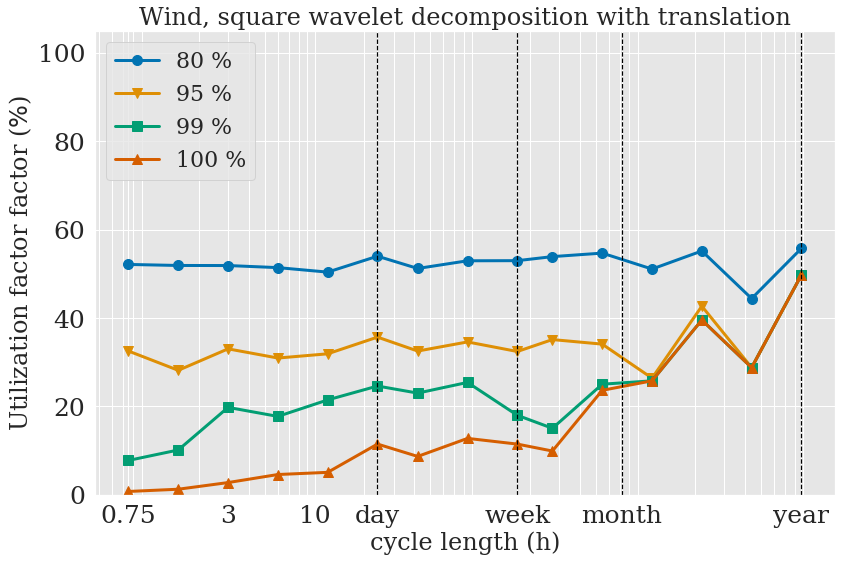

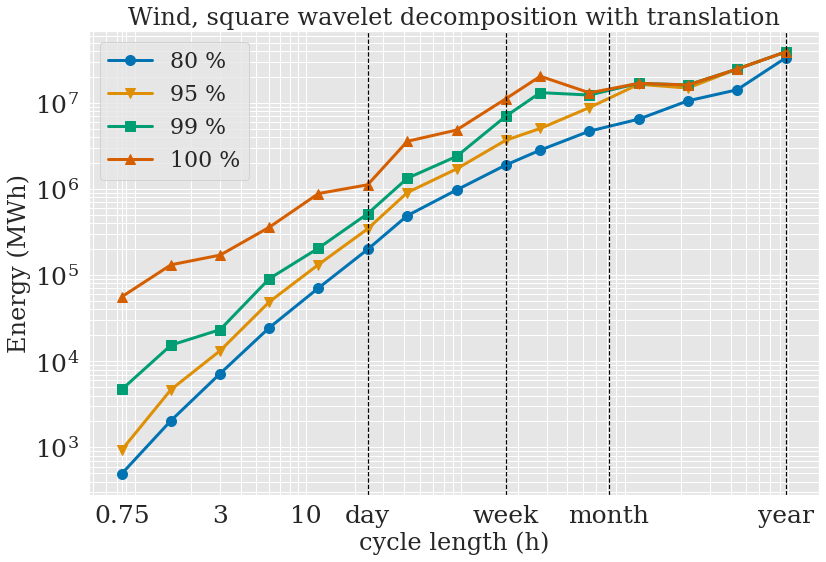

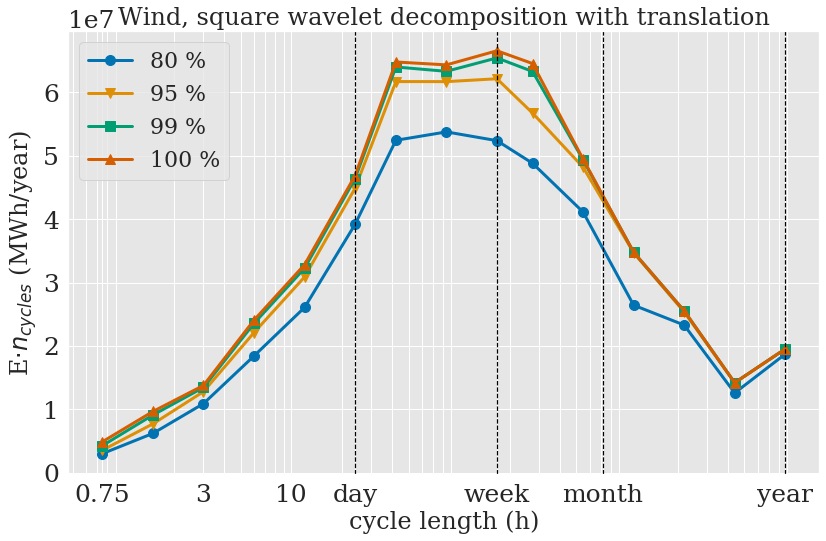

In [45]:
scenario_name = 'Wind, square wavelet decomposition with translation'
conso = stacked_betas_square['Consommation']
prod =  stacked_betas_square['Eolien']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_wind = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_wind['emax'], results_square_wind['pmax'], results_square_wind['n'], results_square_wind['uf'], results_square_wind['serv'],
         time_scales, satisfactions, scenario_name )

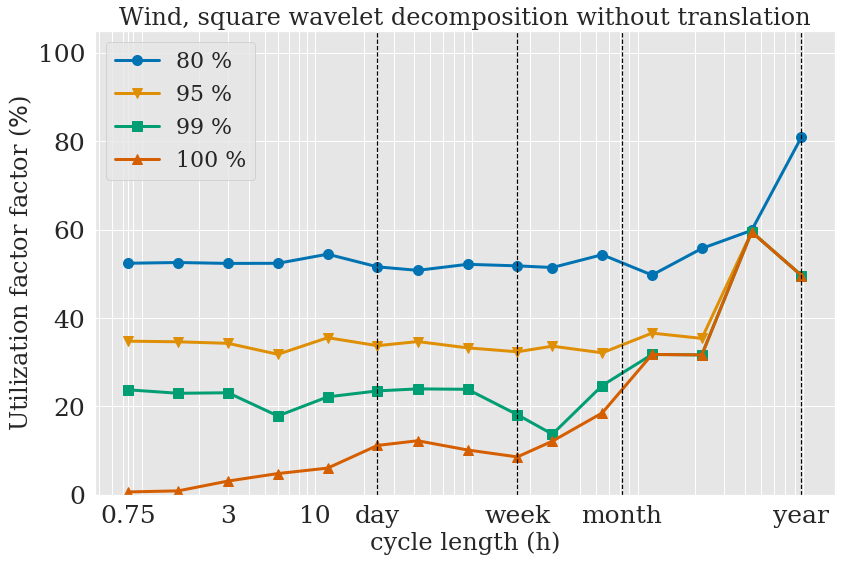

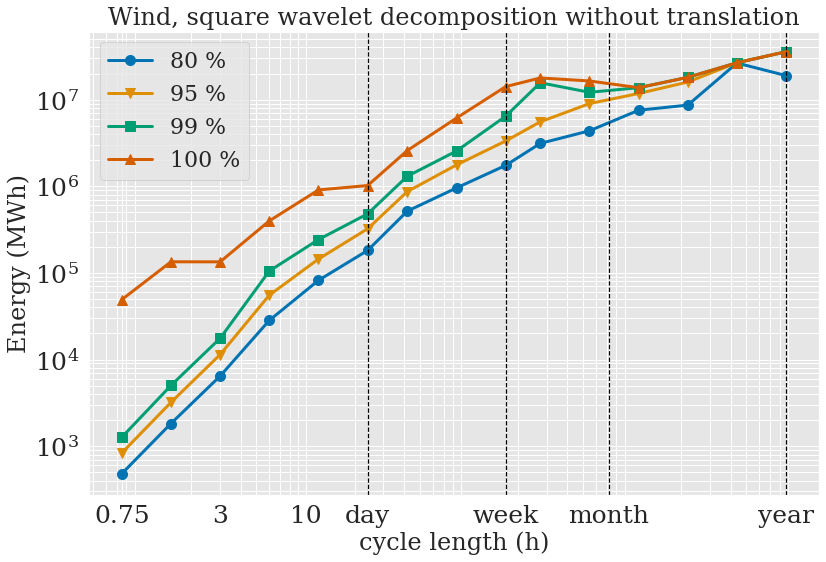

In [46]:
scenario_name = 'Wind, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consommation']
prod =  stacked_betas_square_no_trans['Eolien']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_wind_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_wind_no_trans['emax'], results_square_wind_no_trans['pmax'], results_square_wind_no_trans['n'], results_square_wind_no_trans['uf'], results_square_wind_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

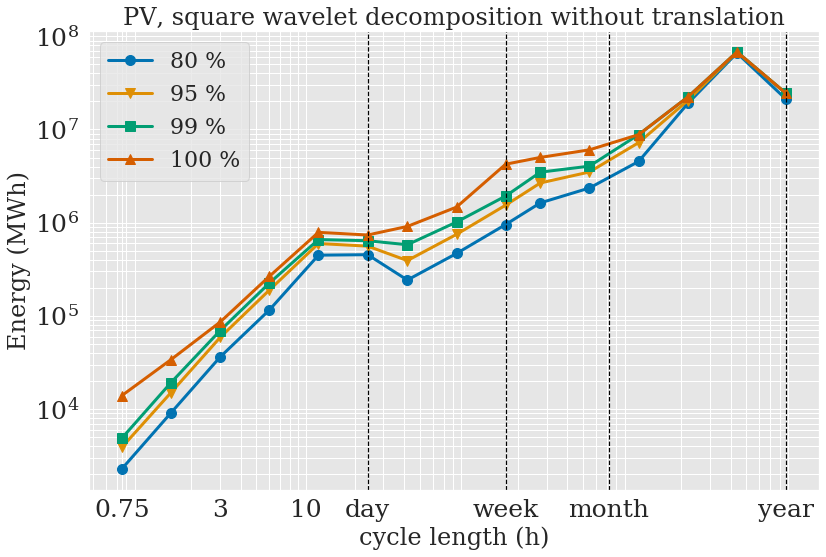

In [47]:
scenario_name = 'PV, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consommation']
prod =  stacked_betas_square_no_trans['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_PV_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_PV_no_trans['emax'], results_square_PV_no_trans['pmax'], results_square_PV_no_trans['n'], results_square_PV_no_trans['uf'], results_square_PV_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

# Energy mix definition

## PPE 2028 scenario,

In [48]:
Wind_share_PPE = 0.164
PV_share_PPE = 0.091



In [49]:
# import importlib
# importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

# # plt.rc('text', usetex=True)  # To get Latex style in the figures
# # plt.rc('font', family='serif')
# plt.rc('xtick', labelsize=22)
# plt.rc('ytick', labelsize=22)
# plt.rc('lines', linewidth=2)
# plt.rcParams.update({'font.size': 40})

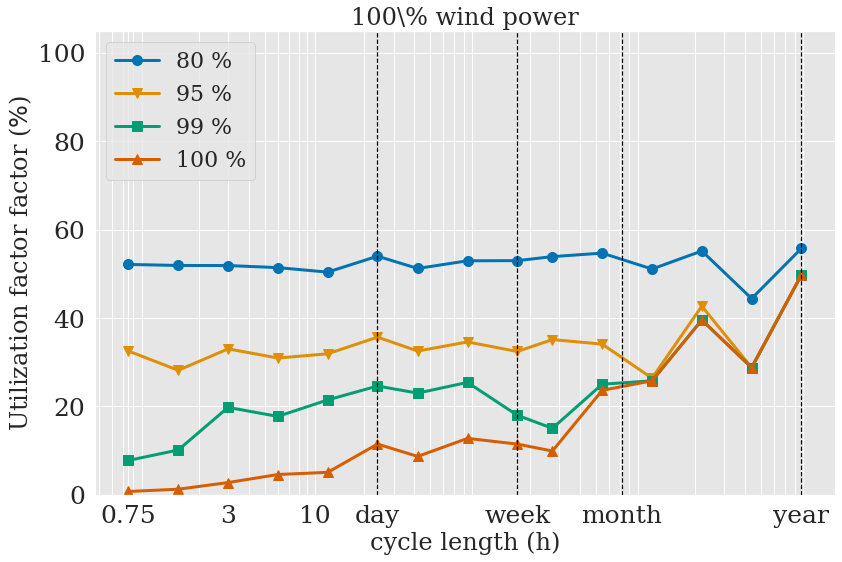

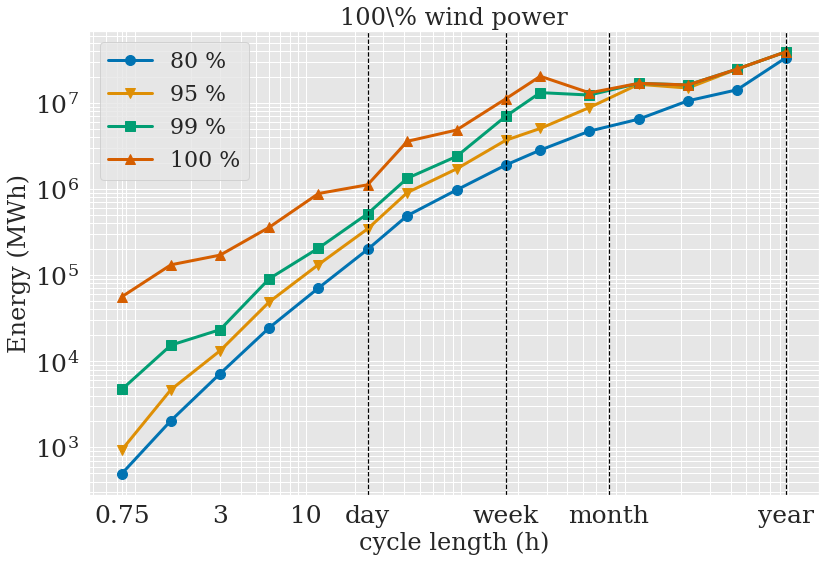

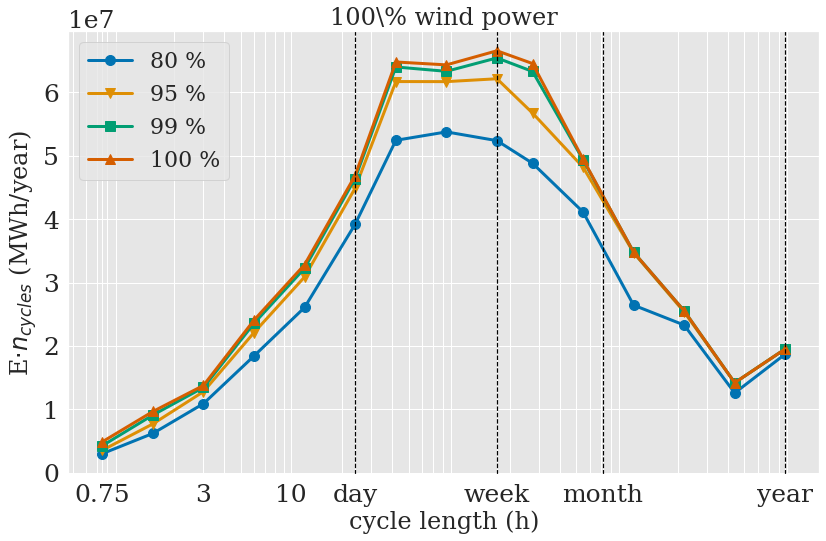

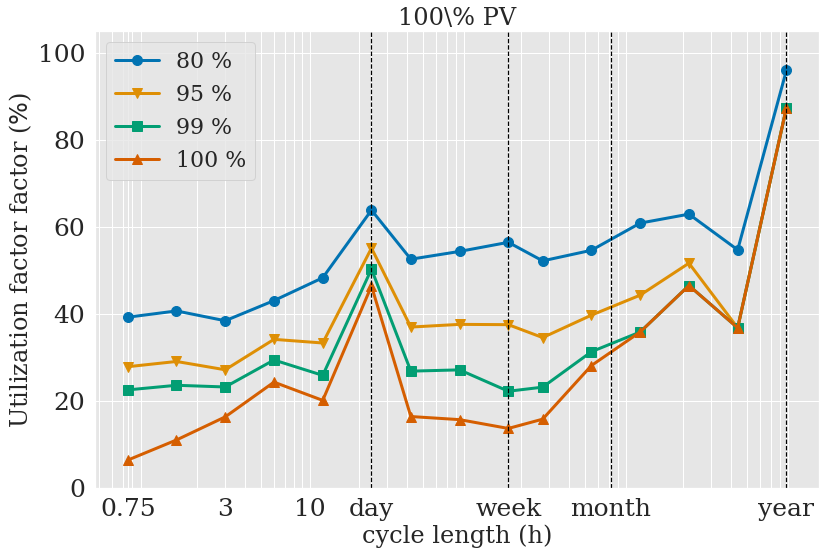

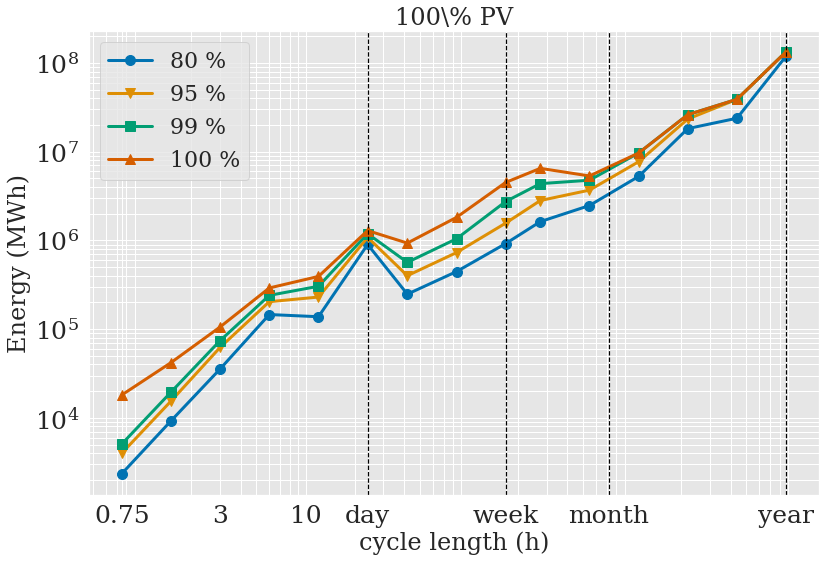

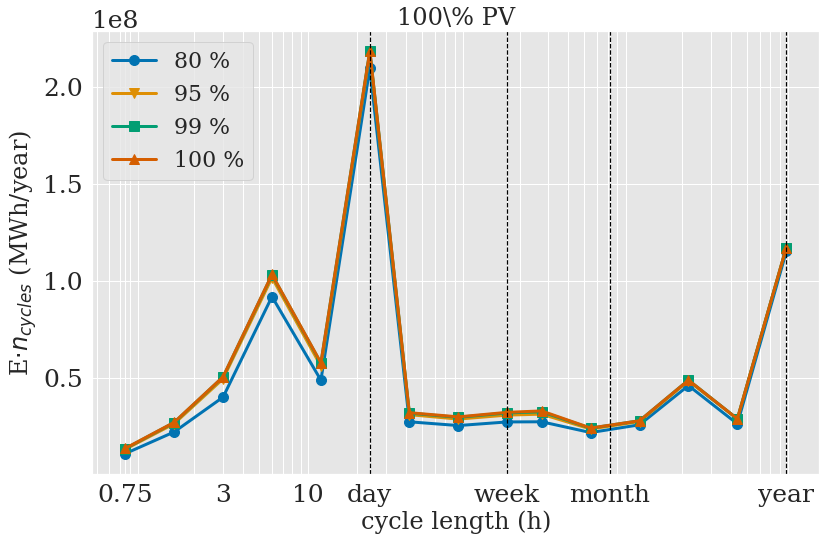

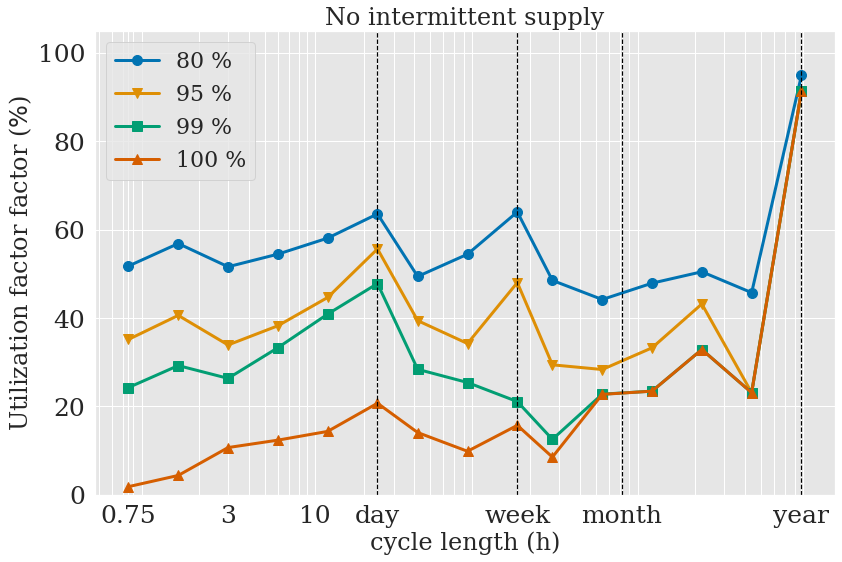

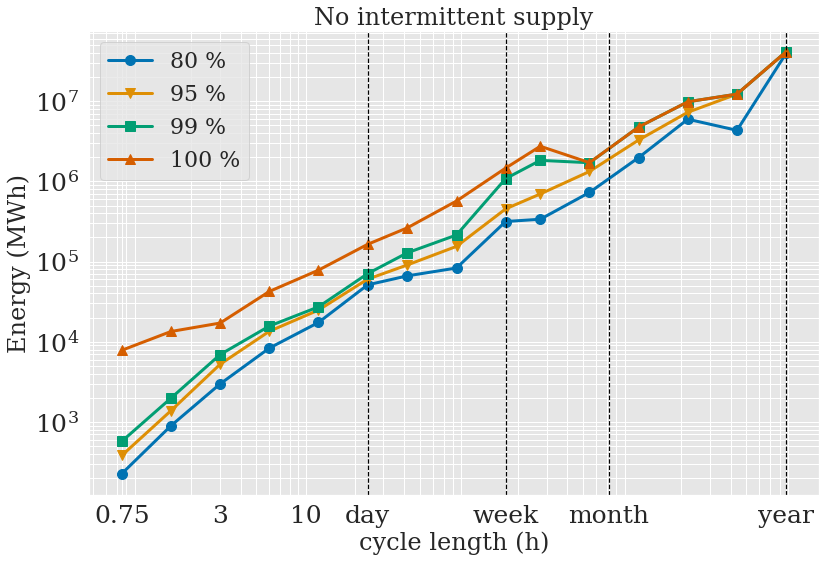

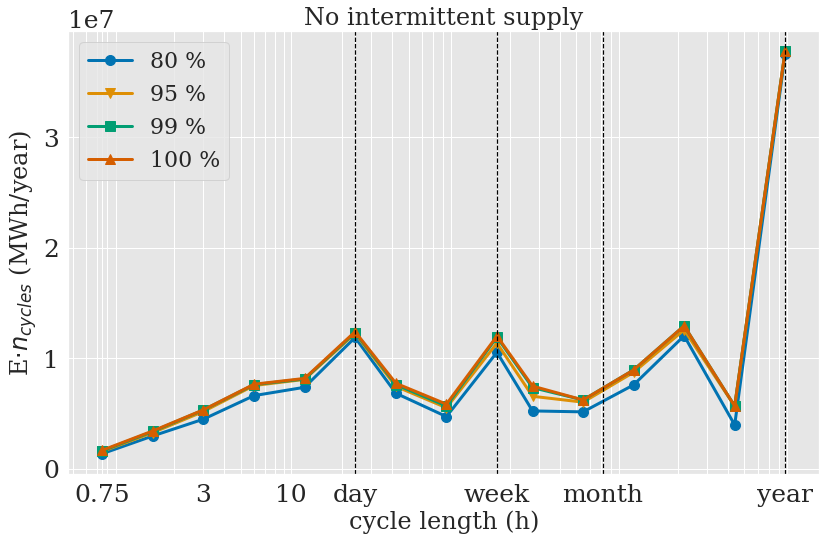

In [50]:
# ---- Signal definition
Conso = stacked_betas_square['Consommation'][0:365*64*7]
PV =  stacked_betas_square['Solaire'][0:365*64*7]
Wind =  stacked_betas_square['Eolien'][0:365*64*7]
# -------
pmc_wind = [np.array(Wind[i]) - np.array(Conso[i]) for i in range(len(time_scales)) ]
pmc_PV = [np.array(PV[i]) - np.array(Conso[i]) for i in range(len(time_scales)) ]
pmc_PPE = [np.array(PV[i])*PV_share_PPE + np.array(Wind[i])*Wind_share_PPE - np.array(Conso[i]) for i in range(len(time_scales)) ]
pmc_load = [- np.array(Conso[i]) for i in range(len(time_scales)) ]
# ----------
satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
pmc_list=[pmc_wind, pmc_PV,pmc_PPE,pmc_load]
scenario_names_list = ['100\% wind power', '100\% PV', 'PPE targets', 'No intermittent supply']
for i,pmc in enumerate(pmc_list):
    results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
    plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
             time_scales, satisfactions, scenario_names_list[i] )

# Superposition des différents scénario :
--------------- 
100% PV, éolien, PPE et sans intermittence

In [51]:
# Same results in a list
satisfactions = [95.]
Emax = []
UF = []
Serv = []
for i,pmc in enumerate(pmc_list):
    Emax.append(calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')['emax'])
    UF.append(calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')['uf'])
    Serv.append(calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')['serv'])

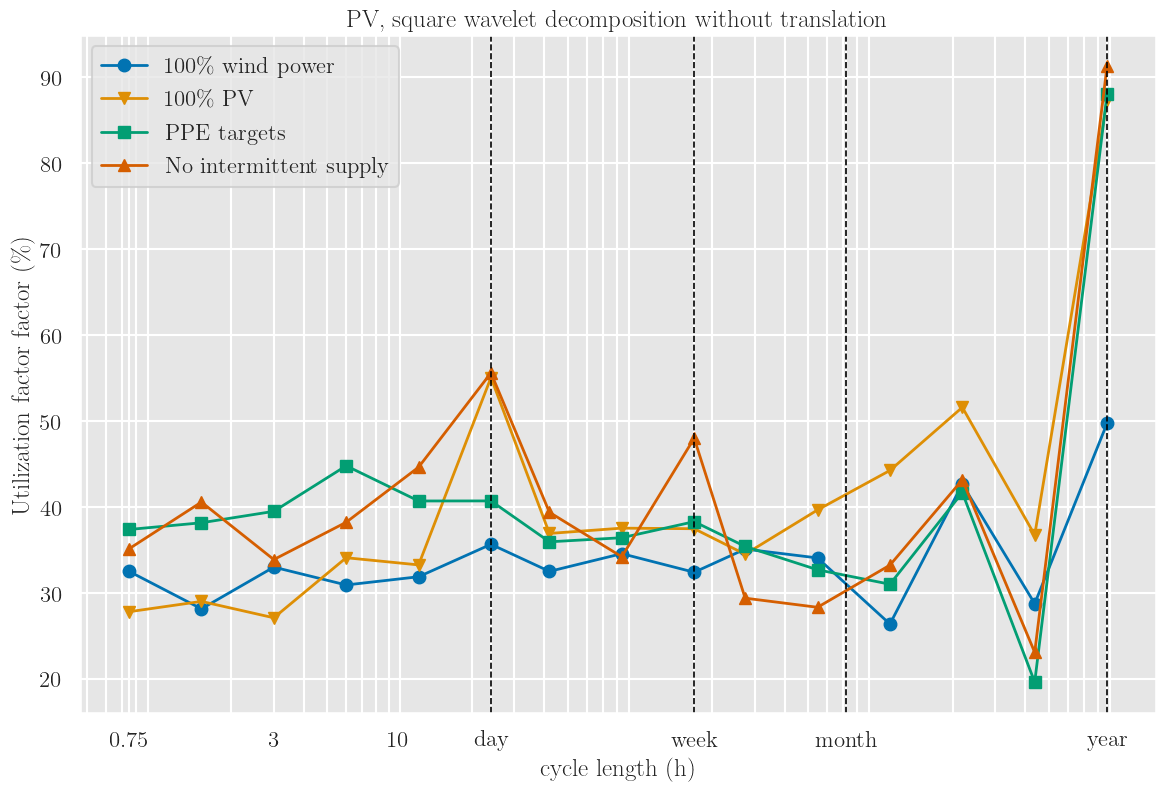

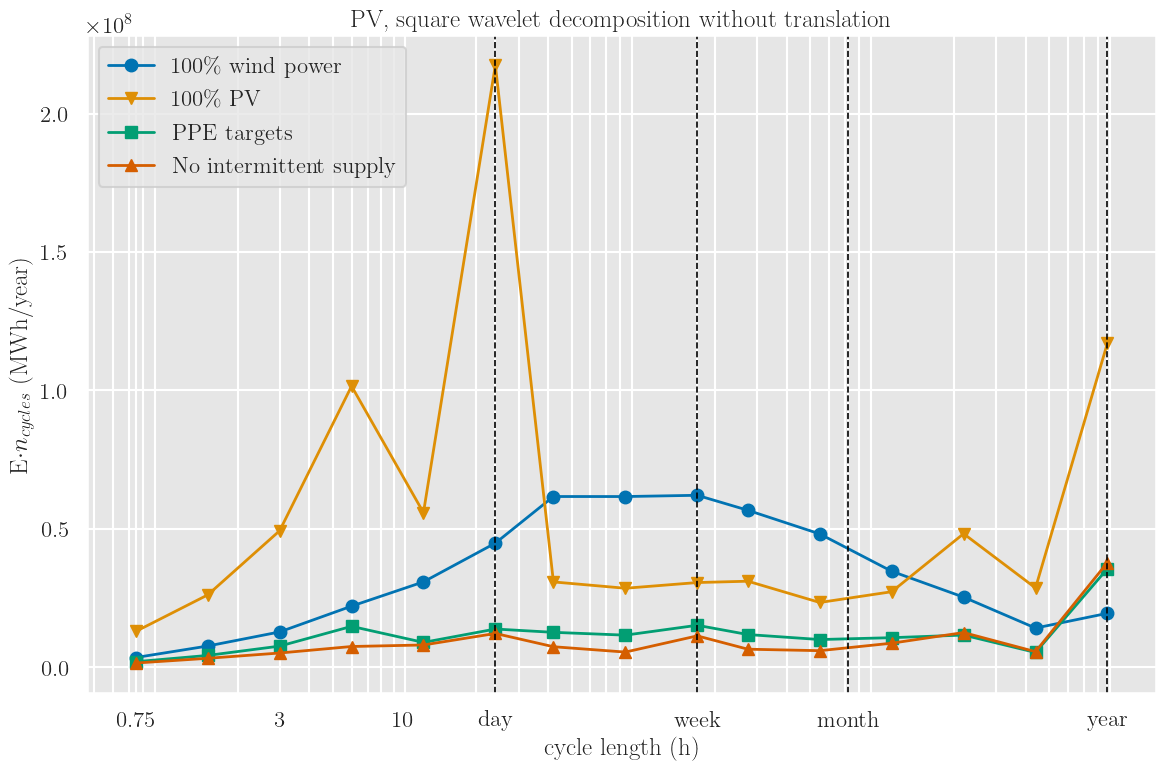

In [52]:
# import importlib
# importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set()
sns.set_context("talk", font_scale=1., rc={"lines.linewidth": 2})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("colorblind")  # set colors palettte
# plt.rc('text', usetex=False)


markers = ['o', 'v', 's', '^', 'o', 'v', 's', '^', 'o', 'v', 's', '^']
markers = ''.join(markers)
mark_size = 10

xcoords = [24, 7 * 24, 30 * 24, 365 * 24]  # verticals black line to spot the day, the week and the month

#     labels = [None, r'10 \%', None, None, r'90 \%',None, None, None, r'100 \%']
labels = [str(satis)+' \%' for satis in satisfactions]

# ----- Figure settings

# plt.rc('text', usetex=True)  # To get Latex style in the figures
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize=25)
# plt.rc('ytick', labelsize=25)
# plt.rc('lines', linewidth=3)

# plt.rc('font', family='xyzxyz')

# plt.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble'] = [r'\boldmath']
# Then , one by one

##---- create figure ----

fwidth = 12.  # total width of the figure in inches
fheight = 8.  # total height of the figure in inches

fig = plt.figure(figsize=(fwidth, fheight))

# ---- define margins -> size in inches / figure dimension ----

left_margin = 0.95 / fwidth
right_margin = 0.2 / fwidth
bottom_margin = 0.5 / fheight
top_margin = 0.25 / fheight

#     #---- create axes ----

#     # dimensions are calculated relative to the figure size

x = left_margin  # horiz. position of bottom-left corner
y = bottom_margin  # vert. position of bottom-left corner
w = 1 - (left_margin + right_margin)  # width of axes
h = 1 - (bottom_margin + top_margin)  # height of axes

ax = fig.add_axes([x, y, w, h])

#     #---- Define the Ylabel position ----

# Location are defined in dimension relative to the figure size

xloc = 0.25 / fwidth
yloc = y + h / 2.

plt.close('all')
##
# Usage factor
plt.figure(figsize=(fwidth, fheight))
plt.rc('text', usetex=True)# To get Latex style in the figures
plt.rc('font', family='serif')

plt.subplot()

plt.ylabel("Utilization factor factor (\%)")
plt.xscale('log')
plt.xlabel("cycle length (h)")
plt.xticks([0.75, 3, 10, 24, 168, 720, 8760], ['0.75', '3', '10', 'day', 'week', 'month', 'year'])
plt.grid(True, which="both")

for i in range(len(UF)):
    plt.plot(time_scales, UF[i], label = scenario_names_list[i], marker= markers[i])

for xc in xcoords:
    plt.axvline(x=xc, linewidth=1.2, color='black', linestyle='--')

ax.set_ylabel('yLabel', fontsize=16, verticalalignment='top',
              horizontalalignment='center')
ax.yaxis.set_label_coords(xloc, yloc, transform=fig.transFigure)
plt.tight_layout()
# plt.legend([lines[i] for i, lab in enumerate(labels) if lab is not None],
#            [labels[i] for i, lab in enumerate(labels) if lab is not None], loc='upper left')
plt.legend(loc='upper left')
# plt.ylim(0, 105)

plt.title(scenario_name)

#     plt.savefig(save_directory+data_name +'_uf' +'.'+ extension,  dpi=600, bbox_inches = 'tight')


##
# Energy
plt.figure(figsize=(fwidth, fheight))
plt.subplot()
plt.yscale('log')
plt.ylabel('Energy (MWh)')
plt.xlabel("cycle length (h)")
plt.xscale('log')
plt.xticks([0.75, 3, 10, 24, 168, 720, 8760], ['0.75', '3', '10', 'day', 'week', 'month', 'year'])

plt.grid(True, which="both")
for i in range(len(UF)):
    plt.plot(time_scales, Emax[i], label = scenario_names_list[i], marker= markers[i])

for xc in xcoords:
    plt.axvline(x=xc, linewidth=1.2, color='black', linestyle='--')

ax.set_ylabel('yLabel', fontsize=16, verticalalignment='top',
              horizontalalignment='center')
ax.yaxis.set_label_coords(xloc, yloc, transform=fig.transFigure)
plt.tight_layout()
plt.legend(loc='upper left')
# plt.title(scenario_name)
#     plt.savefig(save_directory+data_name +'_energy' +'.'+ extension,  dpi=600, bbox_inches = 'tight')

#     ##
# Service
plt.figure(figsize=(fwidth, fheight))
plt.subplot()
plt.xscale('log')
plt.xlabel("cycle length (h)")
plt.ylabel(r"E$\cdot n_{cycles}$ (MWh/year)")
plt.xticks([0.75, 3, 10, 24, 168, 720, 8760], ['0.75', '3', '10', 'day', 'week', 'month', 'year'])
for i in range(len(UF)):
    plt.plot(time_scales, Serv[i], label = scenario_names_list[i], marker= markers[i])
plt.grid(True, which="both")

for xc in xcoords:
    plt.axvline(x=xc, linewidth=1.2, color='black', linestyle='--')

ax.set_ylabel('yLabel', fontsize=16, verticalalignment='top',
              horizontalalignment='center')
ax.yaxis.set_label_coords(xloc, yloc, transform=fig.transFigure)
plt.tight_layout()

plt.legend(loc='upper left')
ax.set_ylabel('yLabel', fontsize=16, verticalalignment='top',
              horizontalalignment='center')
ax.yaxis.set_label_coords(xloc, yloc, transform=fig.transFigure)
# plt.ylim(0,3e8)
plt.title(scenario_name)

plt.show()

In [53]:
# scenario_names_list = ['100\% wind power', '100\% PV', 'PPE targets', 'No intermittent supply']
Emax_day={}
for i in range(len(Emax)):
    Emax_day[scenario_names_list[i]]= Emax[i][5][0]

In [54]:
keys = Emax_day.keys()
values = Emax_day.values()



In [55]:
plt.figure(figsize=(fwidth, fheight))

sns.set()
# sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.})
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("poster", font_scale=2)

# plt.rc('text', usetex=False)  # To get Latex style in the figures
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize=22)
# plt.rc('ytick', labelsize=22)
# plt.rc('lines', linewidth=2)
# sns.set_palette("colorblind")  # set colors palettte

bars = plt.bar(keys, values)
bars[0].set_color('b')
bars[1].set_color("sandybrown")
bars[2].set_color('g')
bars[3].set_color('r')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.yticks(ticks = [0,1e5, 5e5,1e6])
plt.title('Zoom, linear scale')

Text(0.5, 1.0, 'Zoom, linear scale')

# Heatmaps calculation

In [56]:
def storage_potential_heatmap(Objects, #List of batteries, STEPs, production...
                             Conso,Prod, #stacked betas conso & prod]
                             mean, # mean consumption value in MW
                             pv_ratio, wind_ratio, nuclear_ratio, hydro_ratio,
                             title,#tilte of the heatmap
                             vm=None,# maximum value of the colorbar
                             colorbar=False): # True or False, display the colorbar
# ------- Compute E,P,N as a function of alpha (and the efficiency) -----
# -----------------------------------------------------------------------
    epna_results = epna(Conso, Prod, ndpd,dpy,  vy, vw, vd, satisfactions, efficiencies, time_scales)
    emax = epna_results['emax'] * mean
    pmax = epna_results['pmax'] * mean
    n    = epna_results['n']
    alpha= epna_results['alpha']
    serv = emax*n
    #
    mean_pv = mean *pv_ratio # MW
    mean_wind = mean * wind_ratio
    mean_nuclear = mean * nuclear_ratio
    mean_hydro = mean * hydro_ratio
    #
    pv_power.mean = mean_pv
    wind_power.mean = mean_wind
    nuclear_power.mean = mean_nuclear
    hydro_power.mean = mean_hydro
    #
    esoi_array = compute_esoi(Objects, emax, pmax, n, serv, alpha, 0 )
    # compute_esoi(emax, pmax, n, serv, alpha, mean_wind, mean_pv, mean_nuclear, mean_hydro, sat_index)

    plot_colormap_paper(esoi_array, colorbar, title, vm)

In [57]:

# ---- Storage and production definition -----

## storage cost
# here is defined each technology
#  efficiency, lifetimeCal, zetaP, zetaE, Nmax, GWP, priceE, priceP
# ZetaE: (MJ)prim/(MWh)el,out
# ZetaP: (MJ)prim/(MW)el,out
# Life Time : years

li = Battery(80, 15, 0, 2e+6, 5000)
step = CalendarObject(80, 60, 20e+6, 3.73e+5)
caes = CalendarObject(35, 40, 0, 2.657e+5)
curt = CalendarObject(0, 0.1, 0, 0.)

# efficiency, lifetimeUse,zetaP, zetaE, GWPe, GWPp
eff_P2G = 30
aec = ContiUseObject(eff_P2G, 11.4, 2.4e+6 / (eff_P2G / 100.), 0)
pemfc = ContiUseObject(eff_P2G, 1.14, 1.14e+6, 0)
comp = ContiUseObject(eff_P2G, 10, 2.3e+5 / (eff_P2G / 100.), 0)
steel_storage_H2 = CalendarObject(eff_P2G, 20, 0, 7.e+4 / (eff_P2G / 100.))
# -
wind_power = Production(1e+7, 20, 0., 0.231)
pv_power = Production(2.5e+7, 30, 0., 0.14)
nuclear_power = Production(2.e+7, 60, 0., 0.75)
hydro_power = Production(1.5e+7, 60, 0., 0.28)

Objects = [li, step,caes, curt, aec, pemfc, comp, steel_storage_H2, eff_P2G , wind_power, pv_power,nuclear_power, hydro_power]

In [58]:
# --------- Options of the decomposition -------
# ----------------------------------------------
# Efficiencies for which alpha computation is done
efficiencies = np.arange(0,101,1.)
satisfactions = [95,100]
Conso = stacked_betas_square['Consommation'][0:365*64*7]
PV =  stacked_betas_square['Solaire'][0:365*64*7]
Wind =  stacked_betas_square['Eolien'][0:365*64*7]

C:\Users\AC252489\Documents\These\manuscript_wavelets\heatmaps_functions.py:77: RuntimeWarning: invalid value encountered in double_scalars
  n_satis[s] = sum(np.minimum(dech, dech_satis[s])) / dech_satis[s] / years
C:\Users\AC252489\Documents\These\manuscript_wavelets\heatmaps_functions.py:70: RuntimeWarning: invalid value encountered in add
  dech = np.maximum(0, -alpha_satis[s] + sgn * ((1. + alpha_satis[s]) * betap - betac))
C:\Users\AC252489\Documents\These\manuscript_wavelets\Class.py:18: RuntimeWarning: invalid value encountered in multiply
  energetic_cost = alpha * self.mean * self.zetaP / self.lifetimeCal / self.CF  # MJ_prim


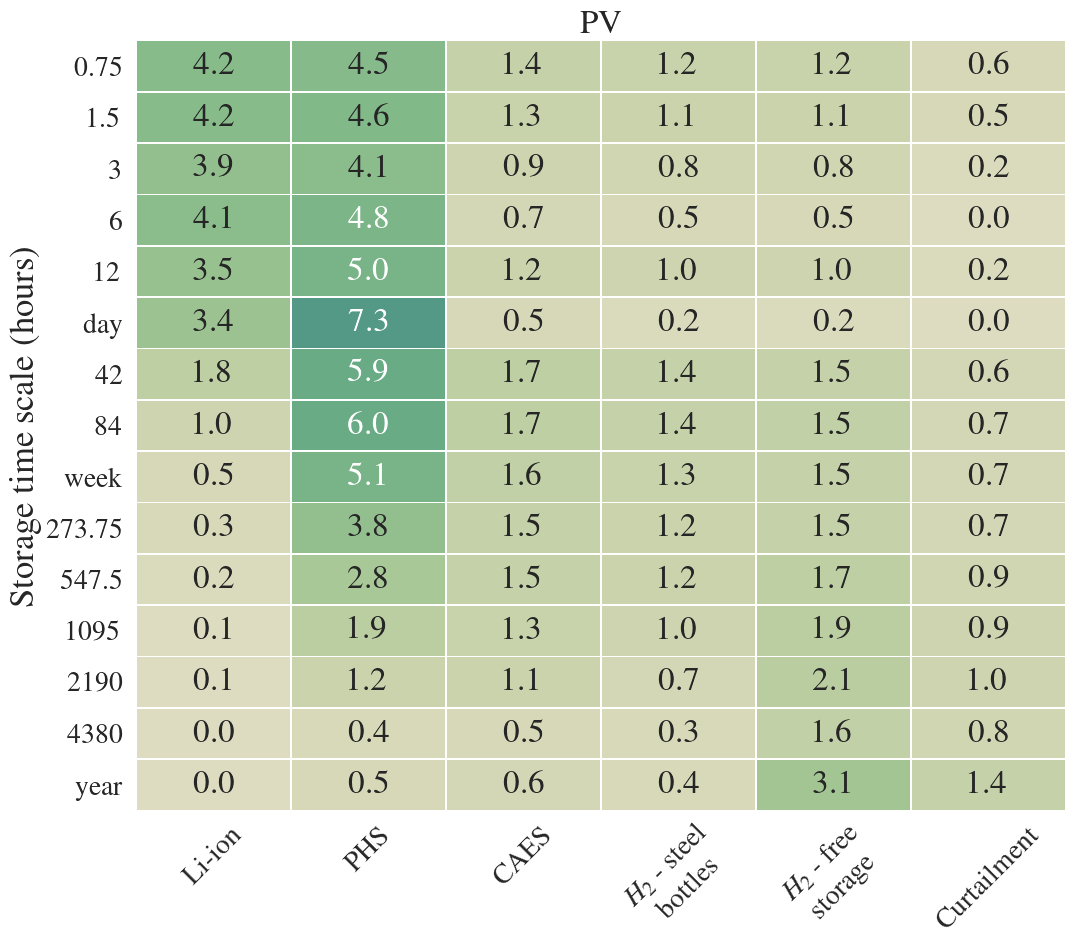

In [59]:
mean = load_factor # MW, pour une conso de 474 (54.1GW)
#
pv_ratio = 1.
wind_ratio = 0.
nuclear_ratio = 0.
hydro_ratio = 0.
#

#
title = 'PV'
#
Prod = PV

storage_potential_heatmap(Objects, Conso,Prod, #stacked betas conso & prod]
                             mean, # mean consumption value in MW
                             pv_ratio, wind_ratio, nuclear_ratio, hydro_ratio,
                             title,#tilte of the heatmap
                             vm= 15,# maximum value of the colorbar
                             colorbar=False) # True or False, display the colorbar

C:\Users\AC252489\Documents\These\manuscript_wavelets\heatmaps_functions.py:70: RuntimeWarning: invalid value encountered in multiply
  dech = np.maximum(0, -alpha_satis[s] + sgn * ((1. + alpha_satis[s]) * betap - betac))


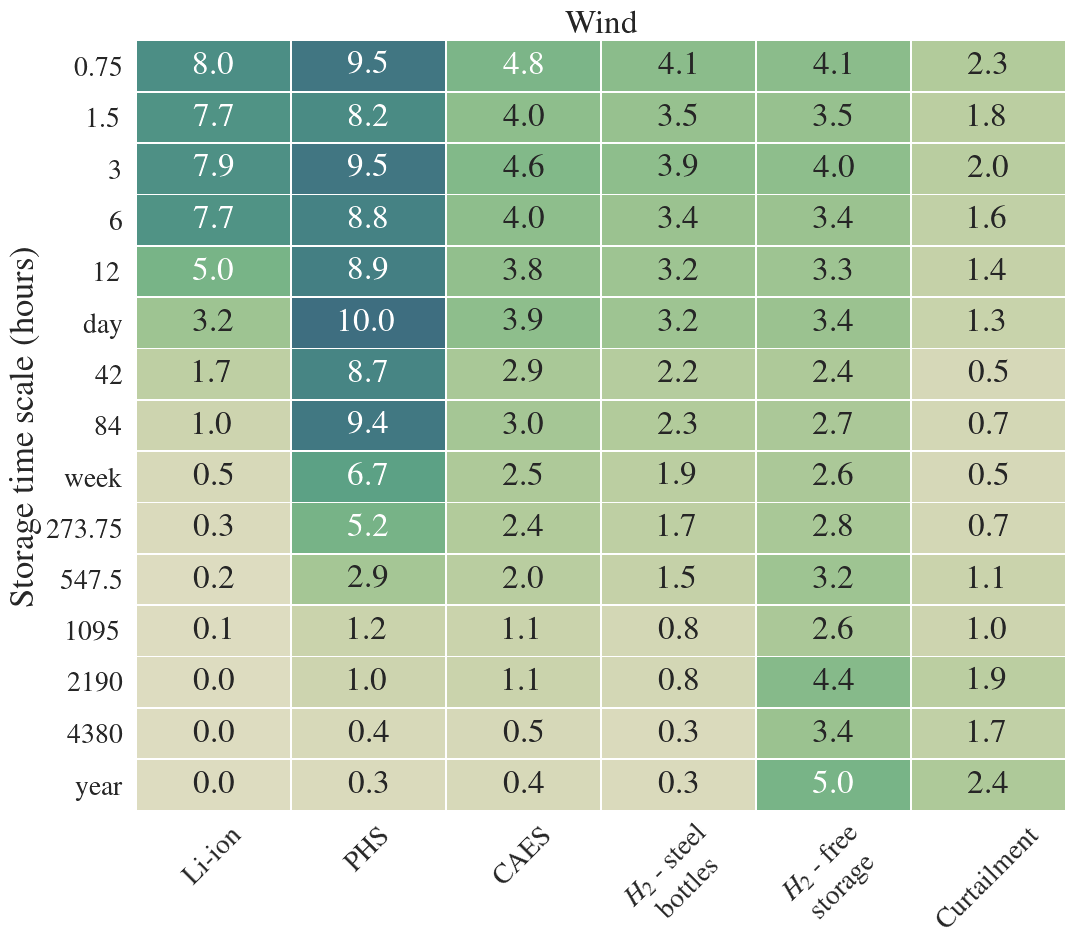

In [60]:
pv_ratio = 0.
wind_ratio = 1.
nuclear_ratio = 0.
hydro_ratio = 0.
#
title = 'Wind'
#
Prod = Wind

storage_potential_heatmap(Objects, Conso,Prod, #stacked betas conso & prod]
                             mean, # mean consumption value in MW
                             pv_ratio, wind_ratio, nuclear_ratio, hydro_ratio,
                             title,#tilte of the heatmap
                             vm= 15,# maximum value of the colorbar
                             colorbar=False) # True or False, display the colorbar

In [61]:
# ---------- Scenario PPE -----------

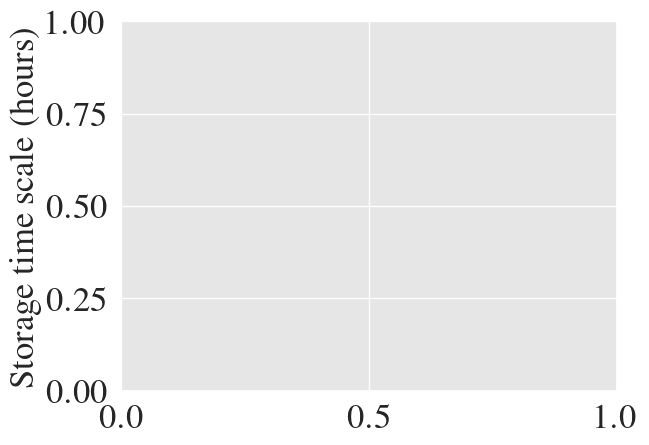

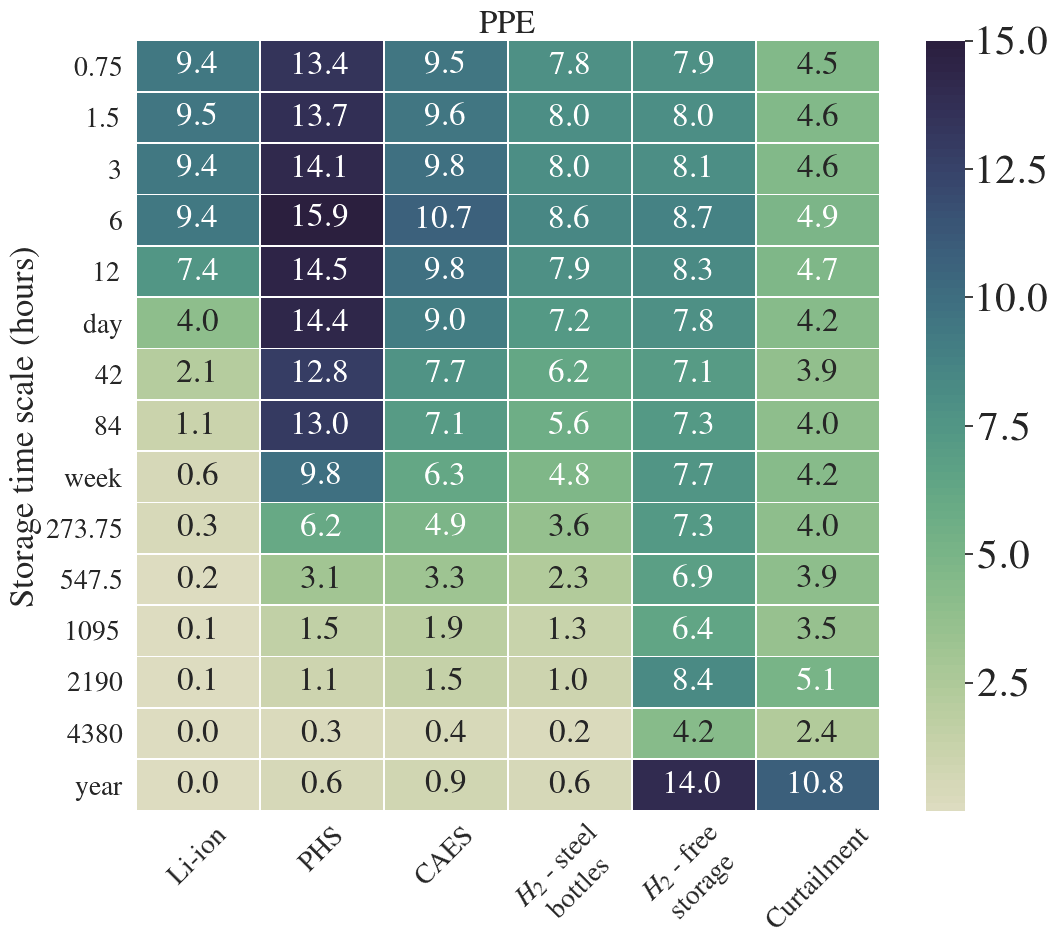

In [62]:

#PPE
pv_ratio = 0.091
wind_ratio = 0.164
nuclear_ratio = 0.616
hydro_ratio = 0.129
#
mean = 66.8*1000 # MW moyen. It includes the total energy production and the share which is exported


title = 'PPE'
#-------------
wind_power = Production(1e+7, 20, 0., 0.231)
pv_power = Production(2.5e+7, 30, 0., 0.14)
nuclear_power = Production(2.e+7, 60, 0., 0.75)
hydro_power = Production(1.5e+7, 60, 0., 0.28)

Objects = [li, step,caes, curt, aec, pemfc, comp, steel_storage_H2, eff_P2G , wind_power, pv_power,nuclear_power, hydro_power]
# ------------

Prod = [np.asarray(Wind[i])*wind_ratio + np.asarray(PV[i])*pv_ratio for i in range(len(PV))]

storage_potential_heatmap(Objects, Conso,Prod, #stacked betas conso & prod]
                             mean, # mean consumption value in MW
                             pv_ratio, wind_ratio, nuclear_ratio, hydro_ratio,
                             title,#tilte of the heatmap
                             vm= 15,# maximum value of the colorbar
                             colorbar=True) # True or False, display the colorbar

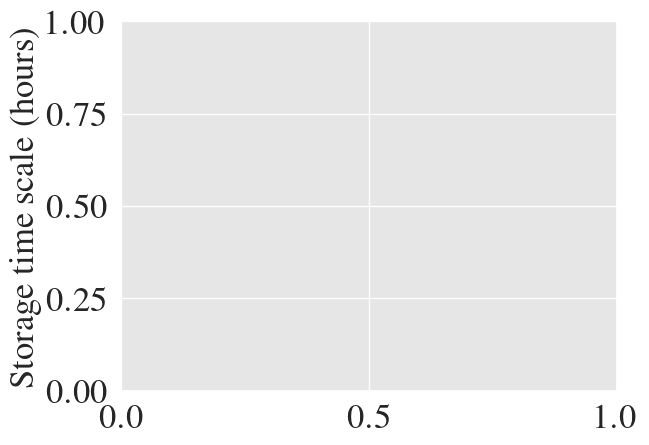

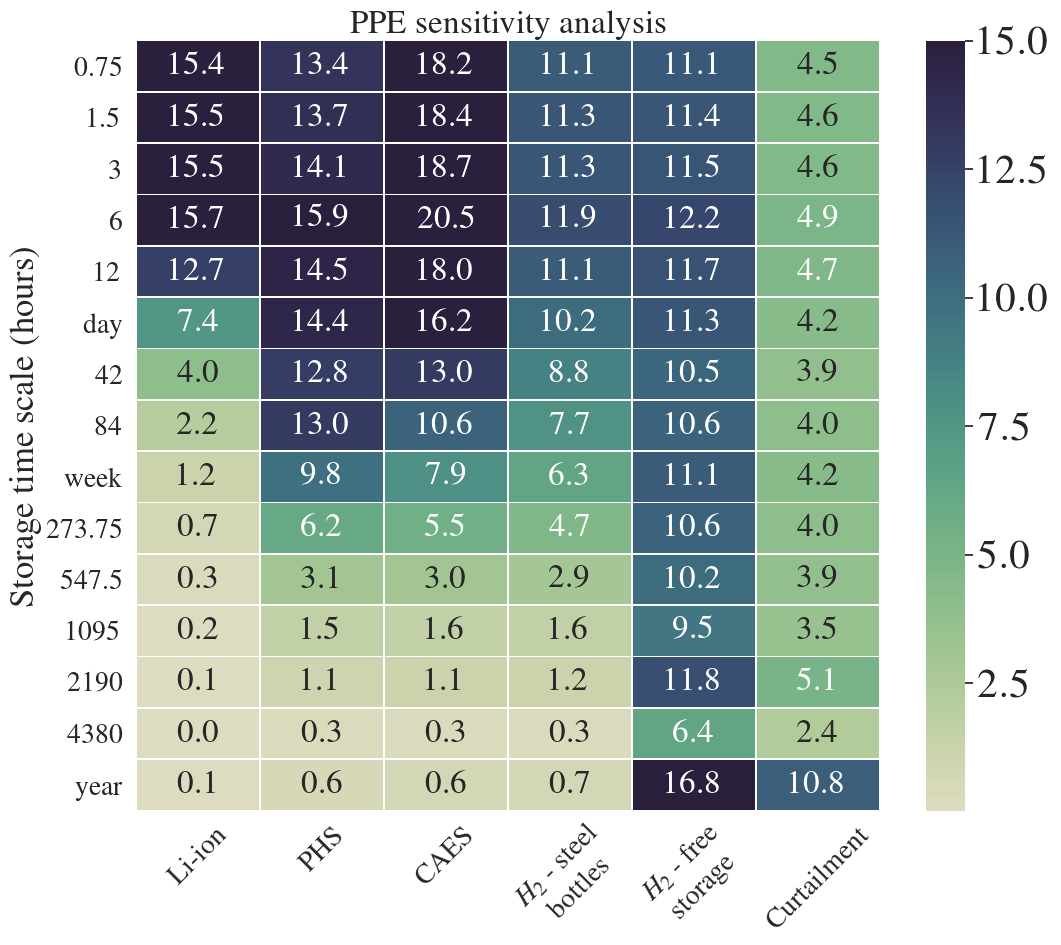

In [63]:
pv_ratio = 0.091
wind_ratio = 0.164
nuclear_ratio = 0.616
hydro_ratio = 0.129

li = Battery(80, 15,0 , 1e+6, 5000)
step = CalendarObject(80, 60, 20e+6, 3.73e+5)
caes = CalendarObject(60, 40, 0, 2.657e+5)
curt = CalendarObject(0, 0.1, 0, 0.)

# efficiency, lifetimeUse,zetaP, zetaE, GWPe, GWPp
eff_P2G = 50
aec = ContiUseObject(eff_P2G, 11.4, 2.4e+6 / (eff_P2G / 100.), 0)
pemfc = ContiUseObject(eff_P2G, 1.14, 1.14e+6, 0)
comp = ContiUseObject(eff_P2G, 10, 2.3e+5 / (eff_P2G / 100.), 0)
steel_storage_H2 = CalendarObject(eff_P2G, 20, 0, 7.e+4 / (eff_P2G / 100.))
#
title = 'PPE sensitivity analysis'
#-------------
wind_power = Production(1e+7, 20, 0., 0.231)
pv_power = Production(2.5e+7, 30, 0., 0.14)
nuclear_power = Production(2.e+7, 60, 0., 0.75)
hydro_power = Production(1.5e+7, 60, 0., 0.28)

Objects = [li, step,caes, curt, aec, pemfc, comp, steel_storage_H2, eff_P2G , wind_power, pv_power,nuclear_power, hydro_power]


Prod = [np.asarray(Wind[i])*wind_ratio + np.asarray(PV[i])*pv_ratio for i in range(len(PV))]

storage_potential_heatmap(Objects, Conso, Prod, #stacked betas conso & prod]
                             mean, # mean consumption value in MW
                             pv_ratio, wind_ratio, nuclear_ratio, hydro_ratio,
                             title,#tilte of the heatmap
                             vm= 15,# maximum value of the colorbar
                             colorbar=True) # True or False, display the colorbar

# ----- Reset mean to the consumption value
# End of PPe scenario
mean = load_factor

## Computing service share for a specific ESOI value

In [64]:
li = Battery(80, 15, 2e+6, 2e+6, 5000)
step = CalendarObject(78, 60, 20e+6, 3.73e+5)
caes = CalendarObject(35, 40, 0, 2.657e+5)
curt = CalendarObject(0, 0.1, 0, 0.)

# efficiency, lifetimeUse,zetaP, zetaE, GWPe, GWPp
eff_P2G = 30
aec = ContiUseObject(eff_P2G, 11.4, 2.4e+6 / (eff_P2G / 100.), 0)
pemfc = ContiUseObject(eff_P2G, 1.14, 1.14e+6, 0)
comp = ContiUseObject(eff_P2G, 10, 2.3e+5 / (eff_P2G / 100.), 0)
steel_storage_H2 = CalendarObject(eff_P2G, 20, 0, 7.e+4 / (eff_P2G / 100.))
# Service and cost share for the year ESOI 13.3 of P2G without H2 storage
#
satisfactions = [95]
# ---- Signal definition
Conso = stacked_betas_square['Consommation'][0:365*64*7]
PV =  stacked_betas_square['Solaire'][0:365*64*7]
Wind =  stacked_betas_square['Eolien'][0:365*64*7]

pmc_PPE = [np.array(PV[i])*PV_share_PPE + np.array(Wind[i])*Wind_share_PPE - np.array(Conso[i]) for i in range(len(time_scales)) ]
# ----------
# -------------------------------
results = calc_epn(pmc_PPE, satisfactions, time_scales, dpy, load_factor, shape = 'square')
Total_sercice = results['serv'][14]
print('Total service (MWh) = ', Total_sercice )
# --------------

mean_pv = mean *pv_ratio # MW
mean_wind = mean * wind_ratio
mean_nuclear = mean * nuclear_ratio
mean_hydro = mean * hydro_ratio
#
pv_power.mean = mean_pv
wind_power.mean = mean_wind
nuclear_power.mean = mean_nuclear
hydro_power.mean = mean_hydro
#
Prod = [np.asarray(Wind[i])*wind_ratio + np.asarray(PV[i])*pv_ratio for i in range(len(PV))]

epna_results = epna(Conso, Prod, ndpd,dpy,  vy, vw, vd, satisfactions, efficiencies, time_scales)
emax = epna_results['emax'] * mean
pmax = epna_results['pmax'] * mean
n    = epna_results['n']
alpha= epna_results['alpha']
serv = emax*n

alphaP2G_yr = alpha[14,30]
print('alpha year P2G =',alpha[14,30])
print('service storage (GWh) =',serv[14,30])
print('Total service (GWh)=',serv[14,-1])


Total service (MWh) =  [35644033.28049915]
alpha year P2G = [0.09193134]
service storage (GWh) = [13698441.27734531]
Total service (GWh)= [35644033.28049915]


In [65]:
mean

54000.0

In [66]:
cost_aec = aec.Costs(emax, pmax, n)
cost_pemfc = pemfc.Costs(emax, pmax, n)
cost_comp = comp.Costs(emax, pmax, n)

## production cost

################################
################################
wind_oversizing_cost = wind_power.Costs(alpha)
pv_oversizing_cost = pv_power.Costs(alpha)
nuclear_oversizing_cost = nuclear_power.Costs(alpha)
hydro_oversizing_cost = hydro_power.Costs(alpha)

production_oversizig_cost = wind_oversizing_cost + pv_oversizing_cost + nuclear_oversizing_cost + hydro_oversizing_cost  # primary MJ

compute_esoi(Objects, emax, pmax, n, serv, alpha, 0)
print('total prod cost (MJ prim)', production_oversizig_cost[:, 30 , :]/3600 )

total prod cost (MJ prim) [[ 241507.05984033]
 [ 501058.0186857 ]
 [ 874296.7612272 ]
 [1537660.58742015]
 [1002957.24732528]
 [1625746.66645174]
 [1655395.61583617]
 [1491559.86849033]
 [1850711.00250673]
 [1534893.62005397]
 [1366513.88075201]
 [1574764.62896818]
 [1233270.07334968]
 [1213098.13519437]
 [1772805.76100105]]


In [67]:
wind_oversizing_cost[:,30,:][-1]/3600 # MWh

array([489504.51283321])

In [68]:
pv_oversizing_cost[:,30,:][-1]

array([2.68899156e+09])

In [69]:
nuclear_oversizing_cost[:,30,:][-1]

array([1.35911286e+09])

In [70]:
hydro_oversizing_cost[:,30,:][-1]

array([5.71780073e+08])

In [71]:
storage_cost = cost_aec + cost_pemfc + cost_comp 
storage_cost[-1]/3600 # MWh

array([772501.15283702])

In [72]:
1922156*8760

16838086560